# Учимся обыгрывать казино: RL с блекджеком и Дастином Хоффманом.


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.  

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym: 
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;  
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;  
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;  
* игрок может совершать одно из двух действий:  
  - hit  — взять ещё одну карту;  
  - stand — не брать больше карт;  
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);  
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);  
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).  
  
Именно этот простейший вариант блекджека реализован в OpenAI Gym:  
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [1]:
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})


import gym

In [2]:
class Agent:
    def __init__(self, action_size):
        pass 

    def act(self, state):
        pass


class ThresholdAgent(Agent):
    def __init__(self, action_size, threshold):
        super().__init__(action_size)
        self.threshold = threshold
        self.action_size = action_size
    
    def act(self, state):
        if state[0] < self.threshold:
            action = 1
        else:
            action = 0
        return action
    
    
class EpsilonGreedyAgent(Agent):
    def __init__(self, action_size, agent, eps=0.1):
        super().__init__(action_size)
        self.agent = agent
        self.eps = eps
        self.action_size = action_size

    def act(self, state):
        if random.random() < self.eps:
            return random.randint(self.action_size)
        else:
            return self.agent.act(state)

In [3]:
env = gym.make('Blackjack-v1', natural=True)

In [4]:
def sample_games(agent, num_games=100_000, env=env):
    reward_list = []
    for _ in range(num_games):
        obs = env.reset()
        while True:
            action = agent.act(obs)
            obs, reward, done, info = env.step(action)
            if done:
                reward_list.append(reward)
                break
    return reward_list

In [5]:
mean_res = []
x_range = range(10, 22)
for threshold in x_range:
    agent = ThresholdAgent(2, threshold)
    res = np.mean(sample_games(agent, num_games=50_000))
    mean_res.append(res)
    print(f"Для порога {threshold} средняя награда равна {res:.3f}")

For threshold 10 mean reward is -0.15812
For threshold 11 mean reward is -0.14026
For threshold 12 mean reward is -0.10126
For threshold 13 mean reward is -0.09112
For threshold 14 mean reward is -0.07966
For threshold 15 mean reward is -0.07288
For threshold 16 mean reward is -0.0719
For threshold 17 mean reward is -0.07882
For threshold 18 mean reward is -0.10838
For threshold 19 mean reward is -0.19506
For threshold 20 mean reward is -0.35162
For threshold 21 mean reward is -0.66076


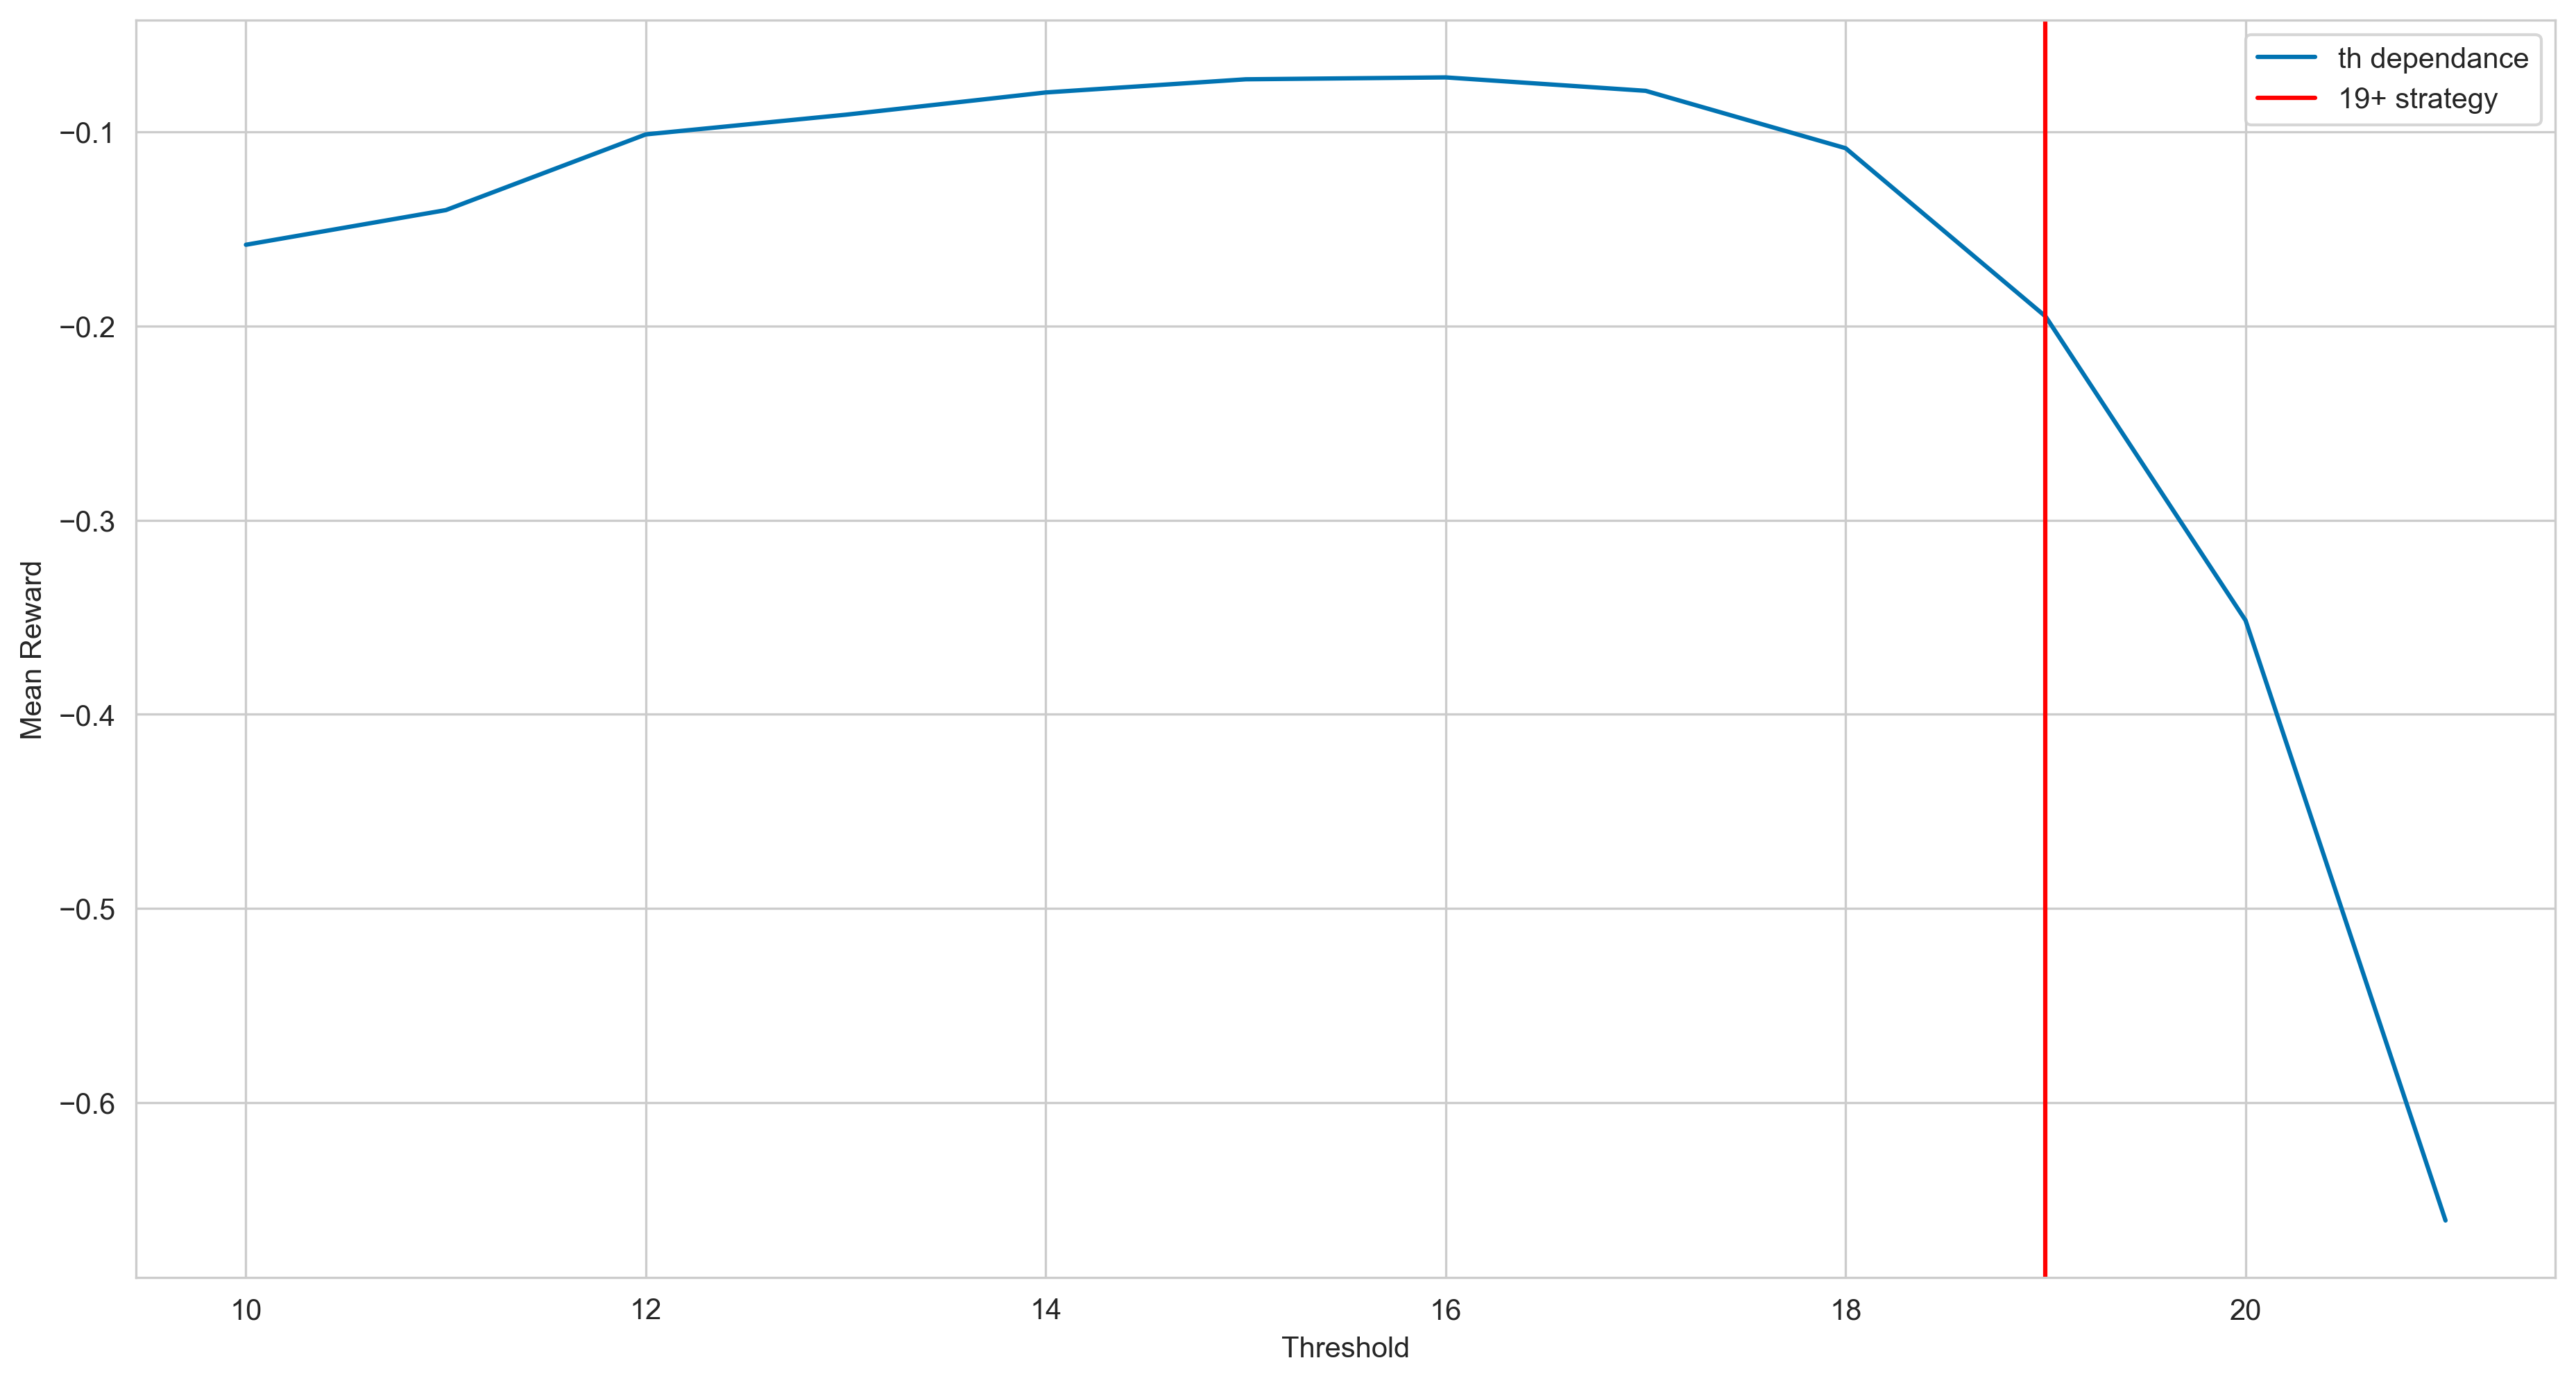

In [6]:
plt.figure(figsize=figsize)
plt.plot(x_range, mean_res, label="Зависимость для порогов")
plt.axvline(19, color="red", label="Стратегия 19+")
plt.xlabel("Порог")
plt.ylabel("Средняя награда")
plt.legend()
plt.show()

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.   
### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

#### Monte-Carlo control с on-policy исследованием

##### Подготовительные функции

In [7]:
# constants
nA = 2
nS = 380

In [8]:
def collect_states(env, NUM_GAMES=10_000):
    states = set()
    for _ in range(NUM_GAMES):
        done = False
        observation = env.reset()
        states.add(observation)
        while not done:
            action = random.randint(0, nA - 1)
            observation, reward, done, _ = env.step(action)
            states.add(observation)
    return states

In [9]:
for _ in range(10):
    env = gym.make('Blackjack-v1', natural=True)
    states = collect_states(env)
    if len(states) == nS:
        break
len(states)

380

In [10]:
state_list = list(states)
state_to_idx = {s: i for i, s in enumerate(state_list)}
idx_to_state = {i: s for i, s in enumerate(state_list)}

In [11]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size, eps=0.1):
        super().__init__(action_size)
        self.eps = eps
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(action_size), states_size)
        self.Q = np.zeros((states_size, action_size))

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q=None):
        Q = Q if Q is not None else self.Q
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    
    def get_Q_by_R(self, R, Q_default=None):
        Q = Q_default if Q_default is not None else self.Q
        for s in range(self.states_size):
            for a in range(self.action_size):
                if len(R[s][a]) > 0:
                    Q[s][a] = np.mean(R[s][a])
        self.Q = Q
        return Q

In [12]:
def run_episode_actions(env, agent, eps=0.5):
    observation = env.reset()
    next_action = agent.act(observation) if random.random() > eps else random.randint(0, nA - 1)
    states, actions, rewards = [observation], [next_action], [0]
    for _ in range(1000):
        observation, reward, done, info = env.step(next_action)
        states.append(observation)
        next_action = agent.act(observation) if random.random() > eps else random.randint(0, nA - 1)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards

def update_returns_actions(R, states, actions, rewards, gamma=1.0, R_all=None):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state_to_idx[state]] == -1:
            state_first_visit[state_to_idx[state]] = t
    g = 0
    if R_all is not None:
        _ = [R_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]
    if state_first_visit[state_to_idx[states[-1]]] == len(states)-1:
        R[state_to_idx[states[-1]]][actions[-1]].append(g)
        if R_all is not None:
            R_all[state_to_idx[states[t]]][actions[t]][-1] = g
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[state_to_idx[states[t]]] == t:
            R[state_to_idx[states[t]]][actions[t]].append(g)
            if R_all is not None:
                R_all[state_to_idx[states[t]]][actions[t]][-1] = g
    return R, R_all

In [13]:
def plot_rewards(reward_list, period=1_000):
    x_range = np.arange(len(reward_list)) * period
    plt.figure(figsize=figsize)
    plt.plot(x_range, reward_list)
    plt.xlabel("Сыграно обучающих сессий")
    plt.ylabel(f"Средняя награда за {period} игр")
    plt.show()

def plot_rewards_rolling(reward_list, period=1_000, roll=10):
    x_range = np.arange(len(reward_list)) * period
    plt.figure(figsize=figsize)
    plt.plot(x_range, reward_list, color="cyan", label="Награда")
    plt.plot(x_range, pd.Series(reward_list).rolling(roll).mean(), color="blue", label=f"Скользящее ({roll}) среднее")
    plt.xlabel("Сыграно обучающих сессий")
    plt.ylabel(f"Средняя награда за {period} игр")
    plt.legend()
    plt.show()

In [14]:
tqdm.tqdm_notebook

<function tqdm.tqdm_notebook(*args, **kwargs)>

##### Обучение

In [17]:
def mc_on_policy_train(env, agent, init_episodes=5_000, total_episodes=100_000, gamma=1,
                       eps=0.2, n_check=1_000, num_games=1_000):

    R, R_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ], [ [ [] for _ in range(nA) ] for _ in range(nS) ]

    reward_list = []

    Q = agent.Q
    pi = agent.pi

    for _ in range(init_episodes):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)

    for n in tqdm.tqdm_notebook(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)
        Q = agent.get_Q_by_R(R, Q_default=agent.Q)
        pi = agent.update_pi(agent.Q)
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games))
            reward_list.append(mean_reward)
            
    return agent, reward_list

<ipython-input-17-6905661f983f>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm.tqdm_notebook(range(total_episodes)):


  0%|          | 0/100000 [00:00<?, ?it/s]

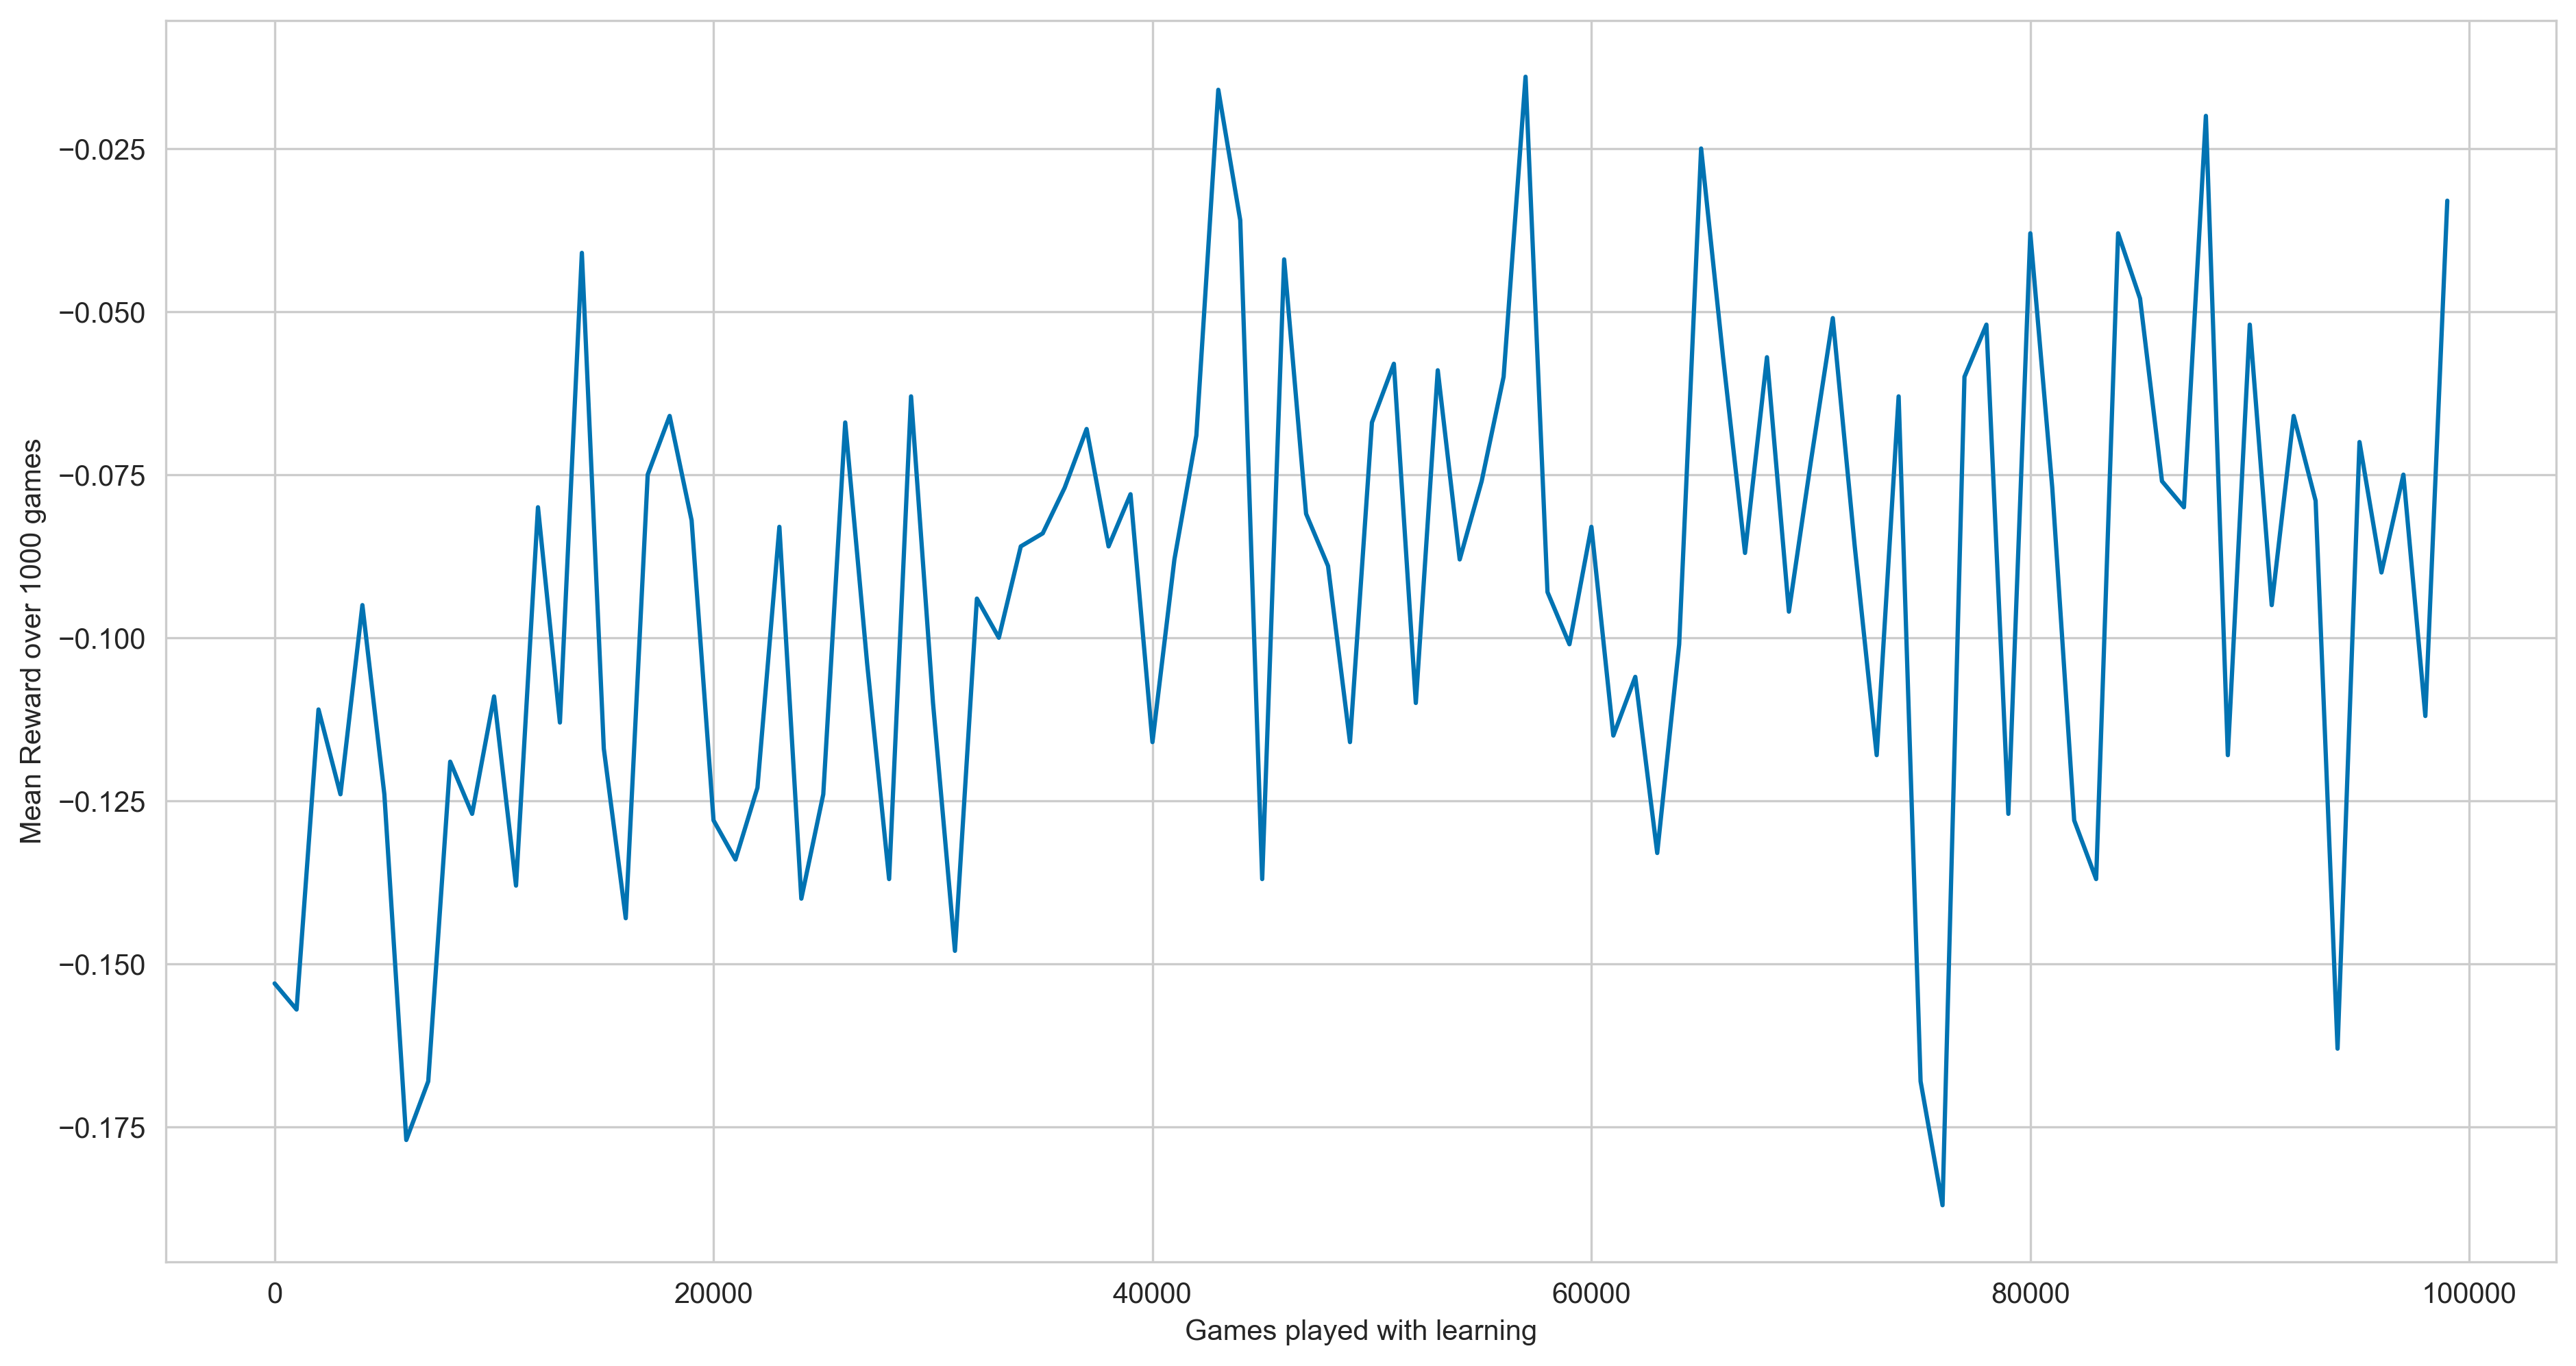

Final agent got mean reward -0.067 for 10000 games


In [18]:
env = gym.make('Blackjack-v1', natural=True)
env._max_episode_steps = 10000
init_episodes, total_episodes = 10_000, 100_000
num_games=10_000
n_check = 1_000

gamma = 1
eps = 0.1

agent = DeterministicPolicyAgent(action_size=2, states_size=len(state_list))

agent, reward_list = mc_on_policy_train(env, agent, init_episodes, total_episodes, gamma, eps, n_check)

plot_rewards(reward_list, n_check)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

#### Monte Carlo control offpolicy

In [19]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size):
        super().__init__(action_size)
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(action_size), states_size)

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q):
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    

In [20]:
def update_lists(s, a, g, w, Q, C, Q_all):
    s = state_to_idx[s]
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]
    if Q_all is not None:
        Q_all[s][a][-1] = g


def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=0.1, gamma=1.0, Q_all=None):
    g, w, prob_best_action = 0., 1., 1 - (nA-1) * epsilon / nA
    if Q_all is not None:
        _ = [Q_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]

    # Обновляем функции для последнего хода
    update_lists(states[-1], actions[-1], g, w, Q, C, Q_all)
    
    for t in range(len(states)-2, -1, -1):
        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if actions[t+1] != pi[state_to_idx[states[t+1]]]:
            break
            
        # Обновляем веса и return
        w = w / ( prob_best_action )
        g =  g * gamma + rewards[t+1]
        
        # Обновляем функции
        update_lists(states[t], actions[t], g, w, Q, C, Q_all)
    return Q, C, Q_all

In [21]:
# def mc_off_policy_train(env, agent, total_episodes=100_000, gamma=1, eps=0.2):

#     Q_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ]

#     reward_list = []

#     Q = np.zeros((nS, nA))
#     pi = agent.update_pi(Q)

#     C = np.zeros((nS, nA), dtype=float)

#     for _ in range(total_episodes):
#         states, actions, rewards = run_episode_actions(env, agent, eps)
#         Q, C, Q_all = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards,
#                                                           epsilon=eps, gamma=gamma, Q_all=Q_all)
#         pi = agent.update_pi(Q)
#         mean_reward = np.mean(sample_games(agent, num_games=1_000))
#         reward_list.append(mean_reward)
    
#     return agent, reward_list

In [53]:
def mc_off_policy_train(env, agent, total_episodes=100_000, gamma=1, eps=0.2, n_check=1_000, num_games=1_000):

    Q_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ]

    reward_list = []

    Q = np.zeros((nS, nA))
    pi = agent.update_pi(Q)

    C = np.zeros((nS, nA), dtype=float)

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        Q, C, Q_all = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards,
                                                          epsilon=eps, gamma=gamma, Q_all=Q_all)
        pi = agent.update_pi(Q)
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games, env=env))
            reward_list.append(mean_reward)
            
    return agent, reward_list

  0%|          | 0/100000 [00:00<?, ?it/s]

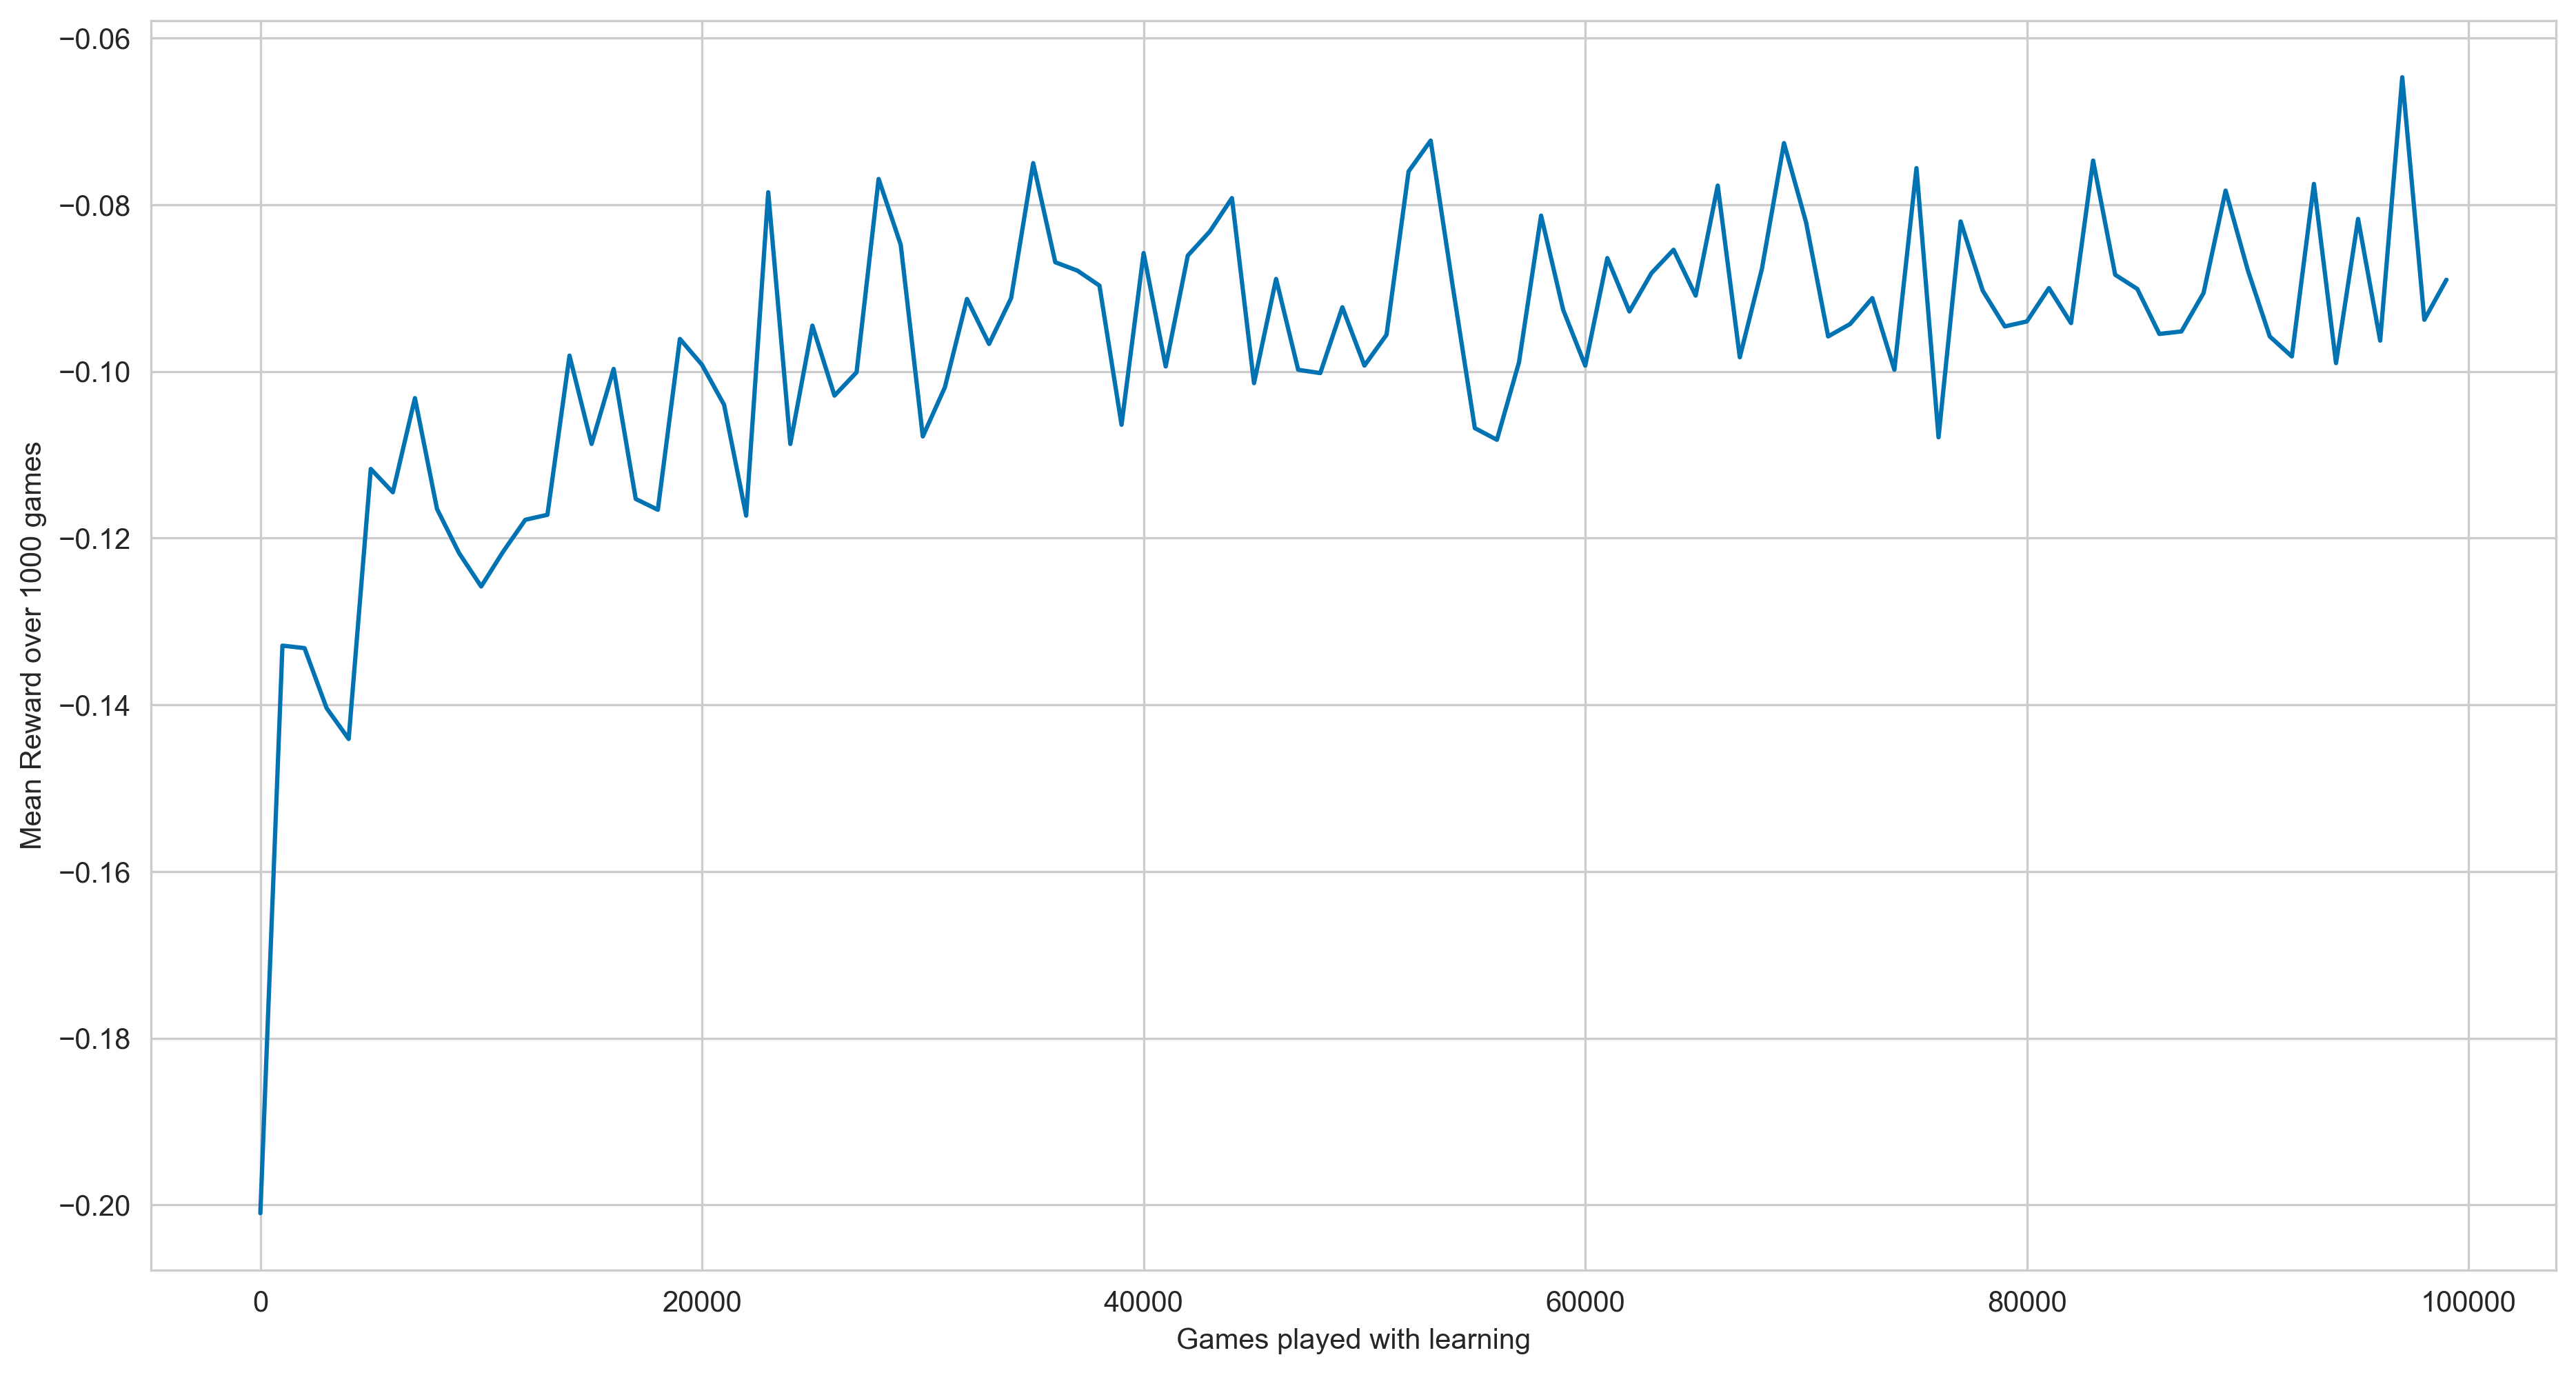

Final agent got mean reward -0.119 for 10000 games


In [23]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.2

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards(reward_list, period)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [56]:
def optuna_reward_mc(trial): 
    eps = trial.suggest_uniform("eps", 0, 1)
    
    agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

    env = gym.make('Blackjack-v1', natural=True)

    # env._max_episode_steps = 10000
    total_episodes = 100_000
    games_check = 10_000
    period = 1e10
    gamma = 1
    eps = 0.2

    agent, _ = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)
    
#     Q = Q_learn(epsilon=epsilon, alpha=alpha, n_episods=100000, leave=False)
    return np.mean(sample_games(agent, num_games=games_check, env=env))

In [25]:
import optuna

In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(optuna_reward_mc, n_trials=20)

[I 2021-10-24 14:41:12,031] A new study created in memory with name: no-name-216a54dc-925f-440f-8e95-7ade51341846


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:41:36,377] Trial 0 finished with value: -0.0912 and parameters: {'eps': 0.9892386311247383}. Best is trial 0 with value: -0.0912.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:42:02,105] Trial 1 finished with value: -0.1007 and parameters: {'eps': 0.964661855081566}. Best is trial 0 with value: -0.0912.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:42:28,750] Trial 2 finished with value: -0.0934 and parameters: {'eps': 0.8504323860808146}. Best is trial 0 with value: -0.0912.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:42:55,742] Trial 3 finished with value: -0.0774 and parameters: {'eps': 0.37252076076058926}. Best is trial 3 with value: -0.0774.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:43:20,717] Trial 4 finished with value: -0.077 and parameters: {'eps': 0.549562426749221}. Best is trial 4 with value: -0.077.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:43:45,443] Trial 5 finished with value: -0.0806 and parameters: {'eps': 0.1194243000983668}. Best is trial 4 with value: -0.077.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:44:11,706] Trial 6 finished with value: -0.067 and parameters: {'eps': 0.019733679960937}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:44:37,973] Trial 7 finished with value: -0.0781 and parameters: {'eps': 0.8056958156091727}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:45:02,879] Trial 8 finished with value: -0.0792 and parameters: {'eps': 0.23396796192816827}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:45:29,194] Trial 9 finished with value: -0.0875 and parameters: {'eps': 0.5043487591092175}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:45:55,116] Trial 10 finished with value: -0.0803 and parameters: {'eps': 0.010928725836876652}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:46:20,484] Trial 11 finished with value: -0.0764 and parameters: {'eps': 0.5905042282483938}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:46:45,740] Trial 12 finished with value: -0.0912 and parameters: {'eps': 0.6479334741739889}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:47:12,891] Trial 13 finished with value: -0.0864 and parameters: {'eps': 0.27567386583480474}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:47:39,903] Trial 14 finished with value: -0.0812 and parameters: {'eps': 0.6850718142121663}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:48:06,351] Trial 15 finished with value: -0.0873 and parameters: {'eps': 0.3623109355170666}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:48:31,346] Trial 16 finished with value: -0.0789 and parameters: {'eps': 0.6236416675259736}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:48:55,828] Trial 17 finished with value: -0.0743 and parameters: {'eps': 0.4380252387520209}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:49:22,450] Trial 18 finished with value: -0.0677 and parameters: {'eps': 0.0021456204026930013}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 14:49:48,079] Trial 19 finished with value: -0.0746 and parameters: {'eps': 0.012244352005413846}. Best is trial 6 with value: -0.067.


  0%|          | 0/100000 [00:00<?, ?it/s]

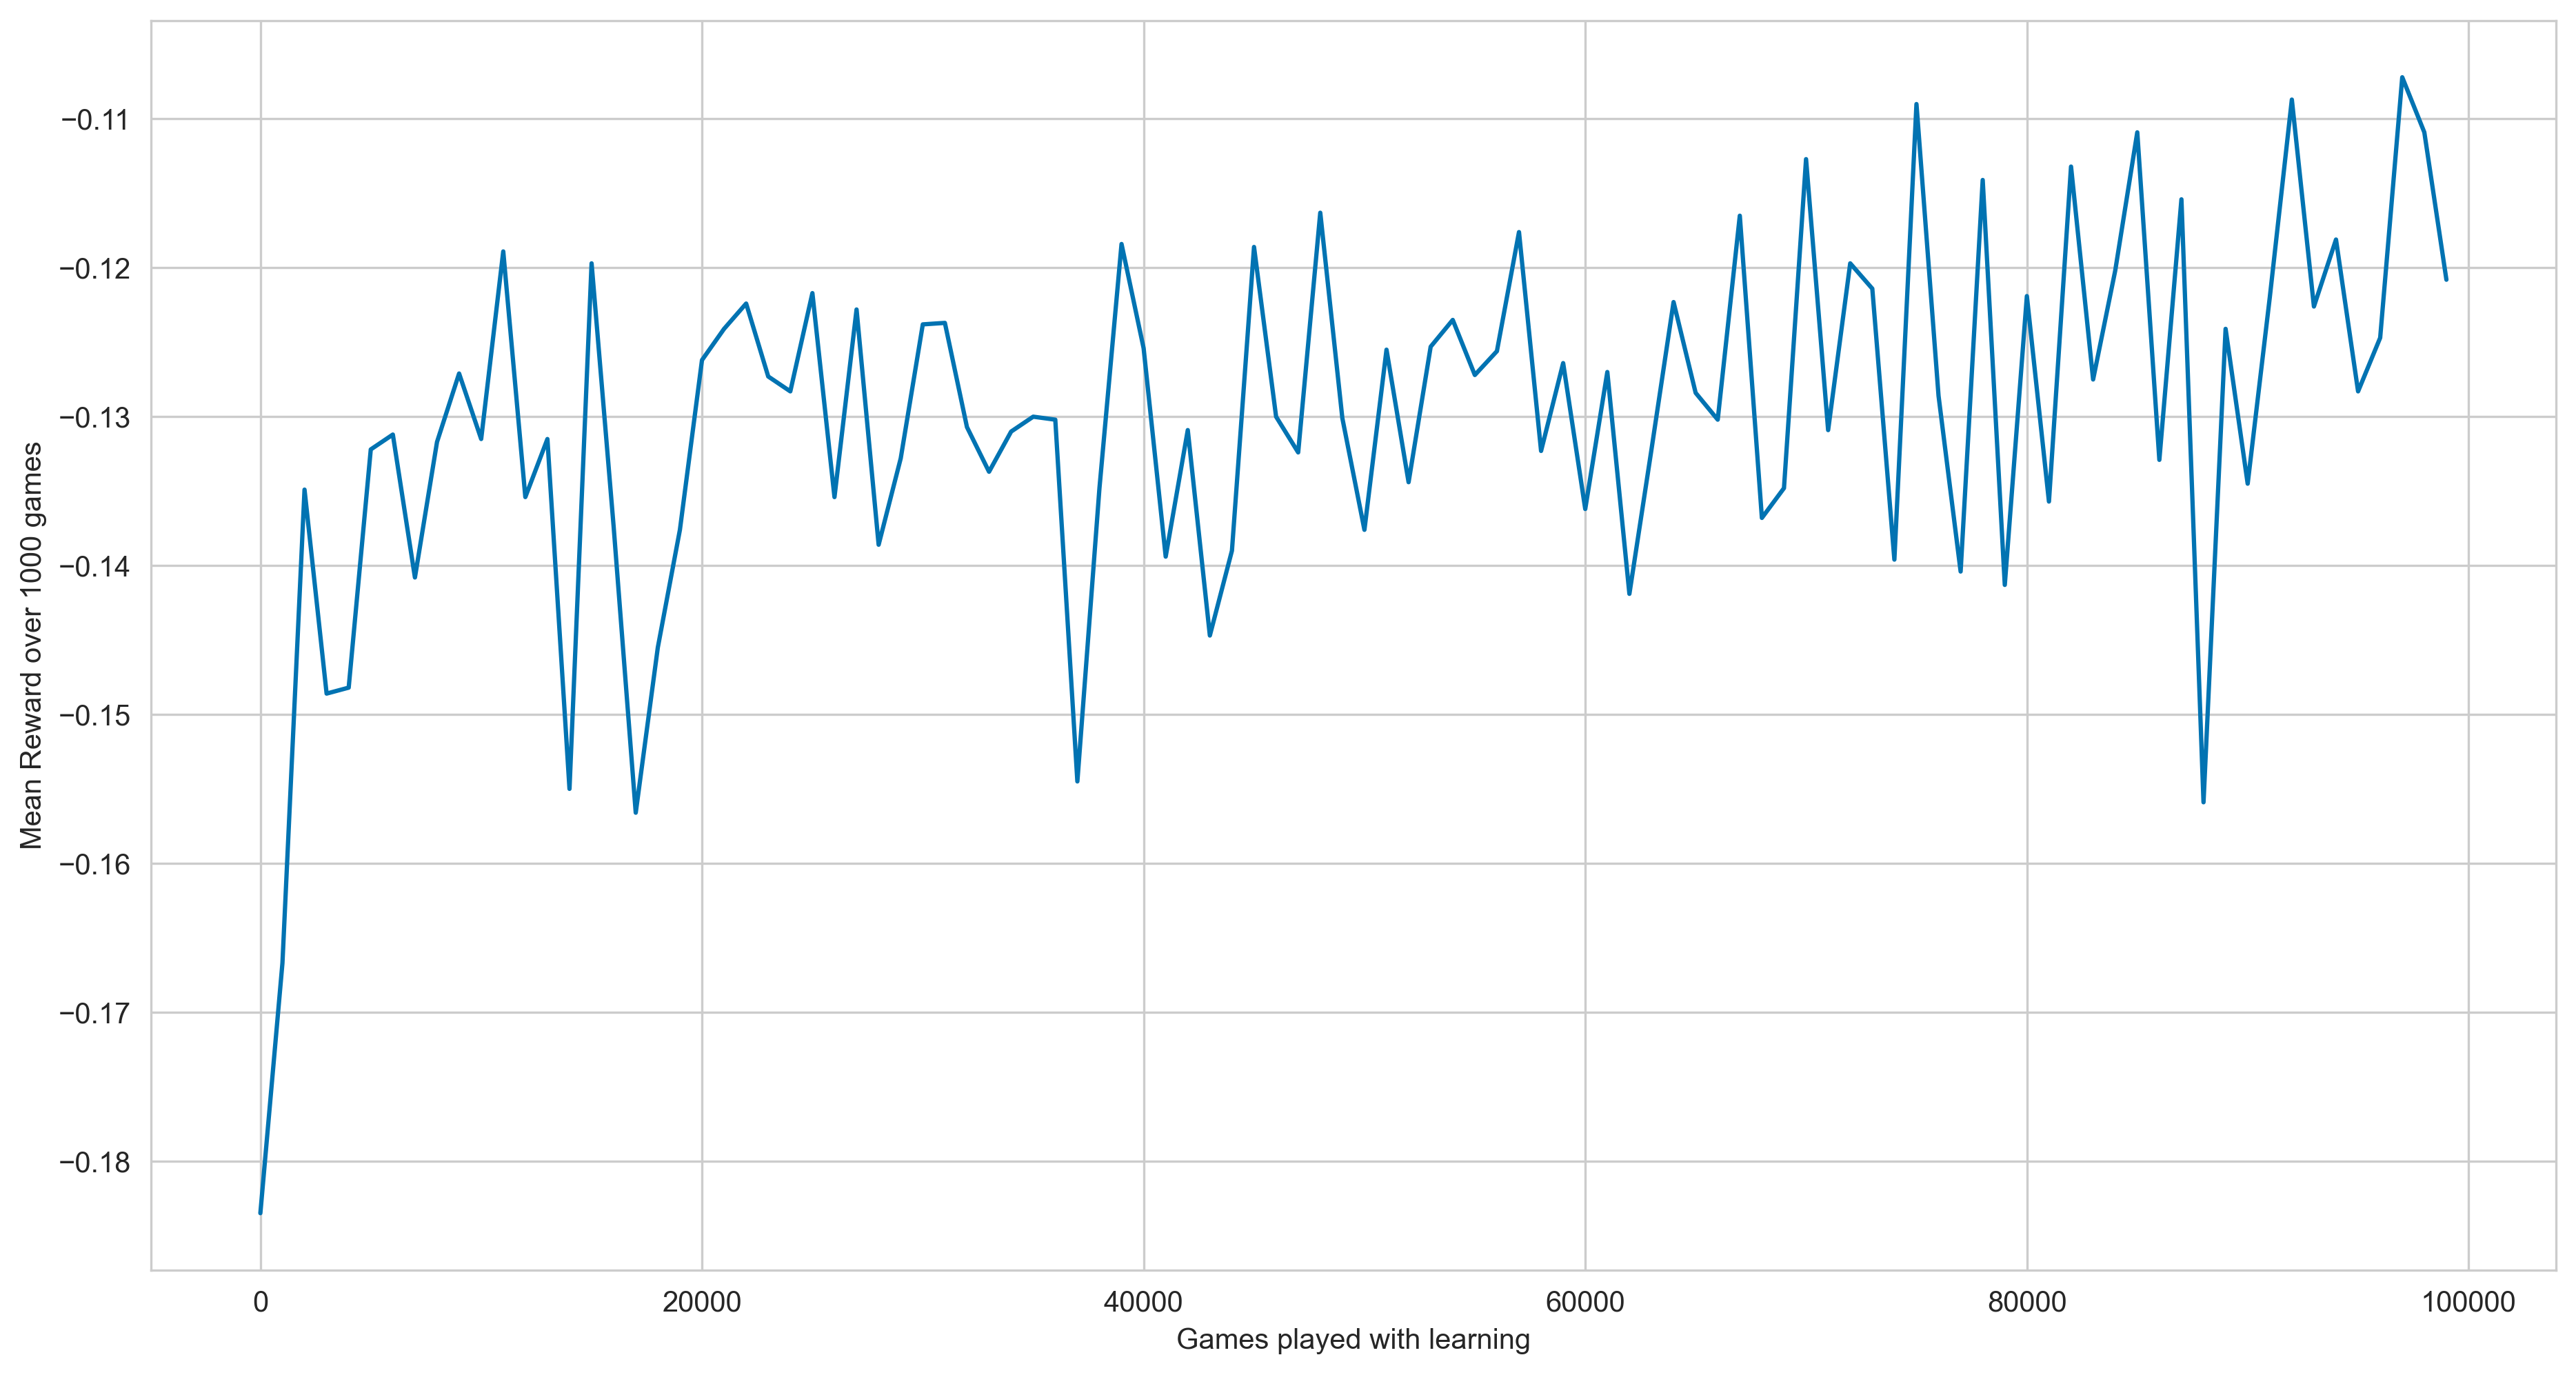

Final agent got mean reward -0.106 for 10000 games


In [35]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.2

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma,
                                         study.best_params["eps"], period, games_check)

plot_rewards(reward_list, period)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

#### Q-Learning

In [28]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size):
        super().__init__(action_size)
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(0, action_size), states_size)

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q):
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    

In [29]:
def Q_learning_episode(env, agent, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    observation = env.reset()
    s = state_to_idx[observation]
    a = agent.act(observation) if random.random() > epsilon else random.randint(0, nA - 1)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime = state_to_idx[observation]
        a_prime = agent.act(observation) if random.random() > epsilon else random.randint(0, nA - 1)
#         s_prime, a_prime = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break
    return reward

In [59]:
def Q_learning_train(env, agent, total_episodes=1_000_000, gamma=1, eps=0.2, alpha=0.1,
                     n_check=1000, num_games=1_000):

#     Q_hist_Qlearn = [ ]
    reward_list = []

    Q = np.zeros((nS, nA))
    pi = agent.update_pi(Q)

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        reward = Q_learning_episode(env, agent, Q, alpha=alpha, epsilon=eps, gamma=gamma)
        pi = agent.update_pi(Q)
#         Q_hist_Qlearn.append(np.copy(Q))
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games, env=env))
            reward_list.append(mean_reward)
    
    return agent, reward_list

  0%|          | 0/200000 [00:00<?, ?it/s]

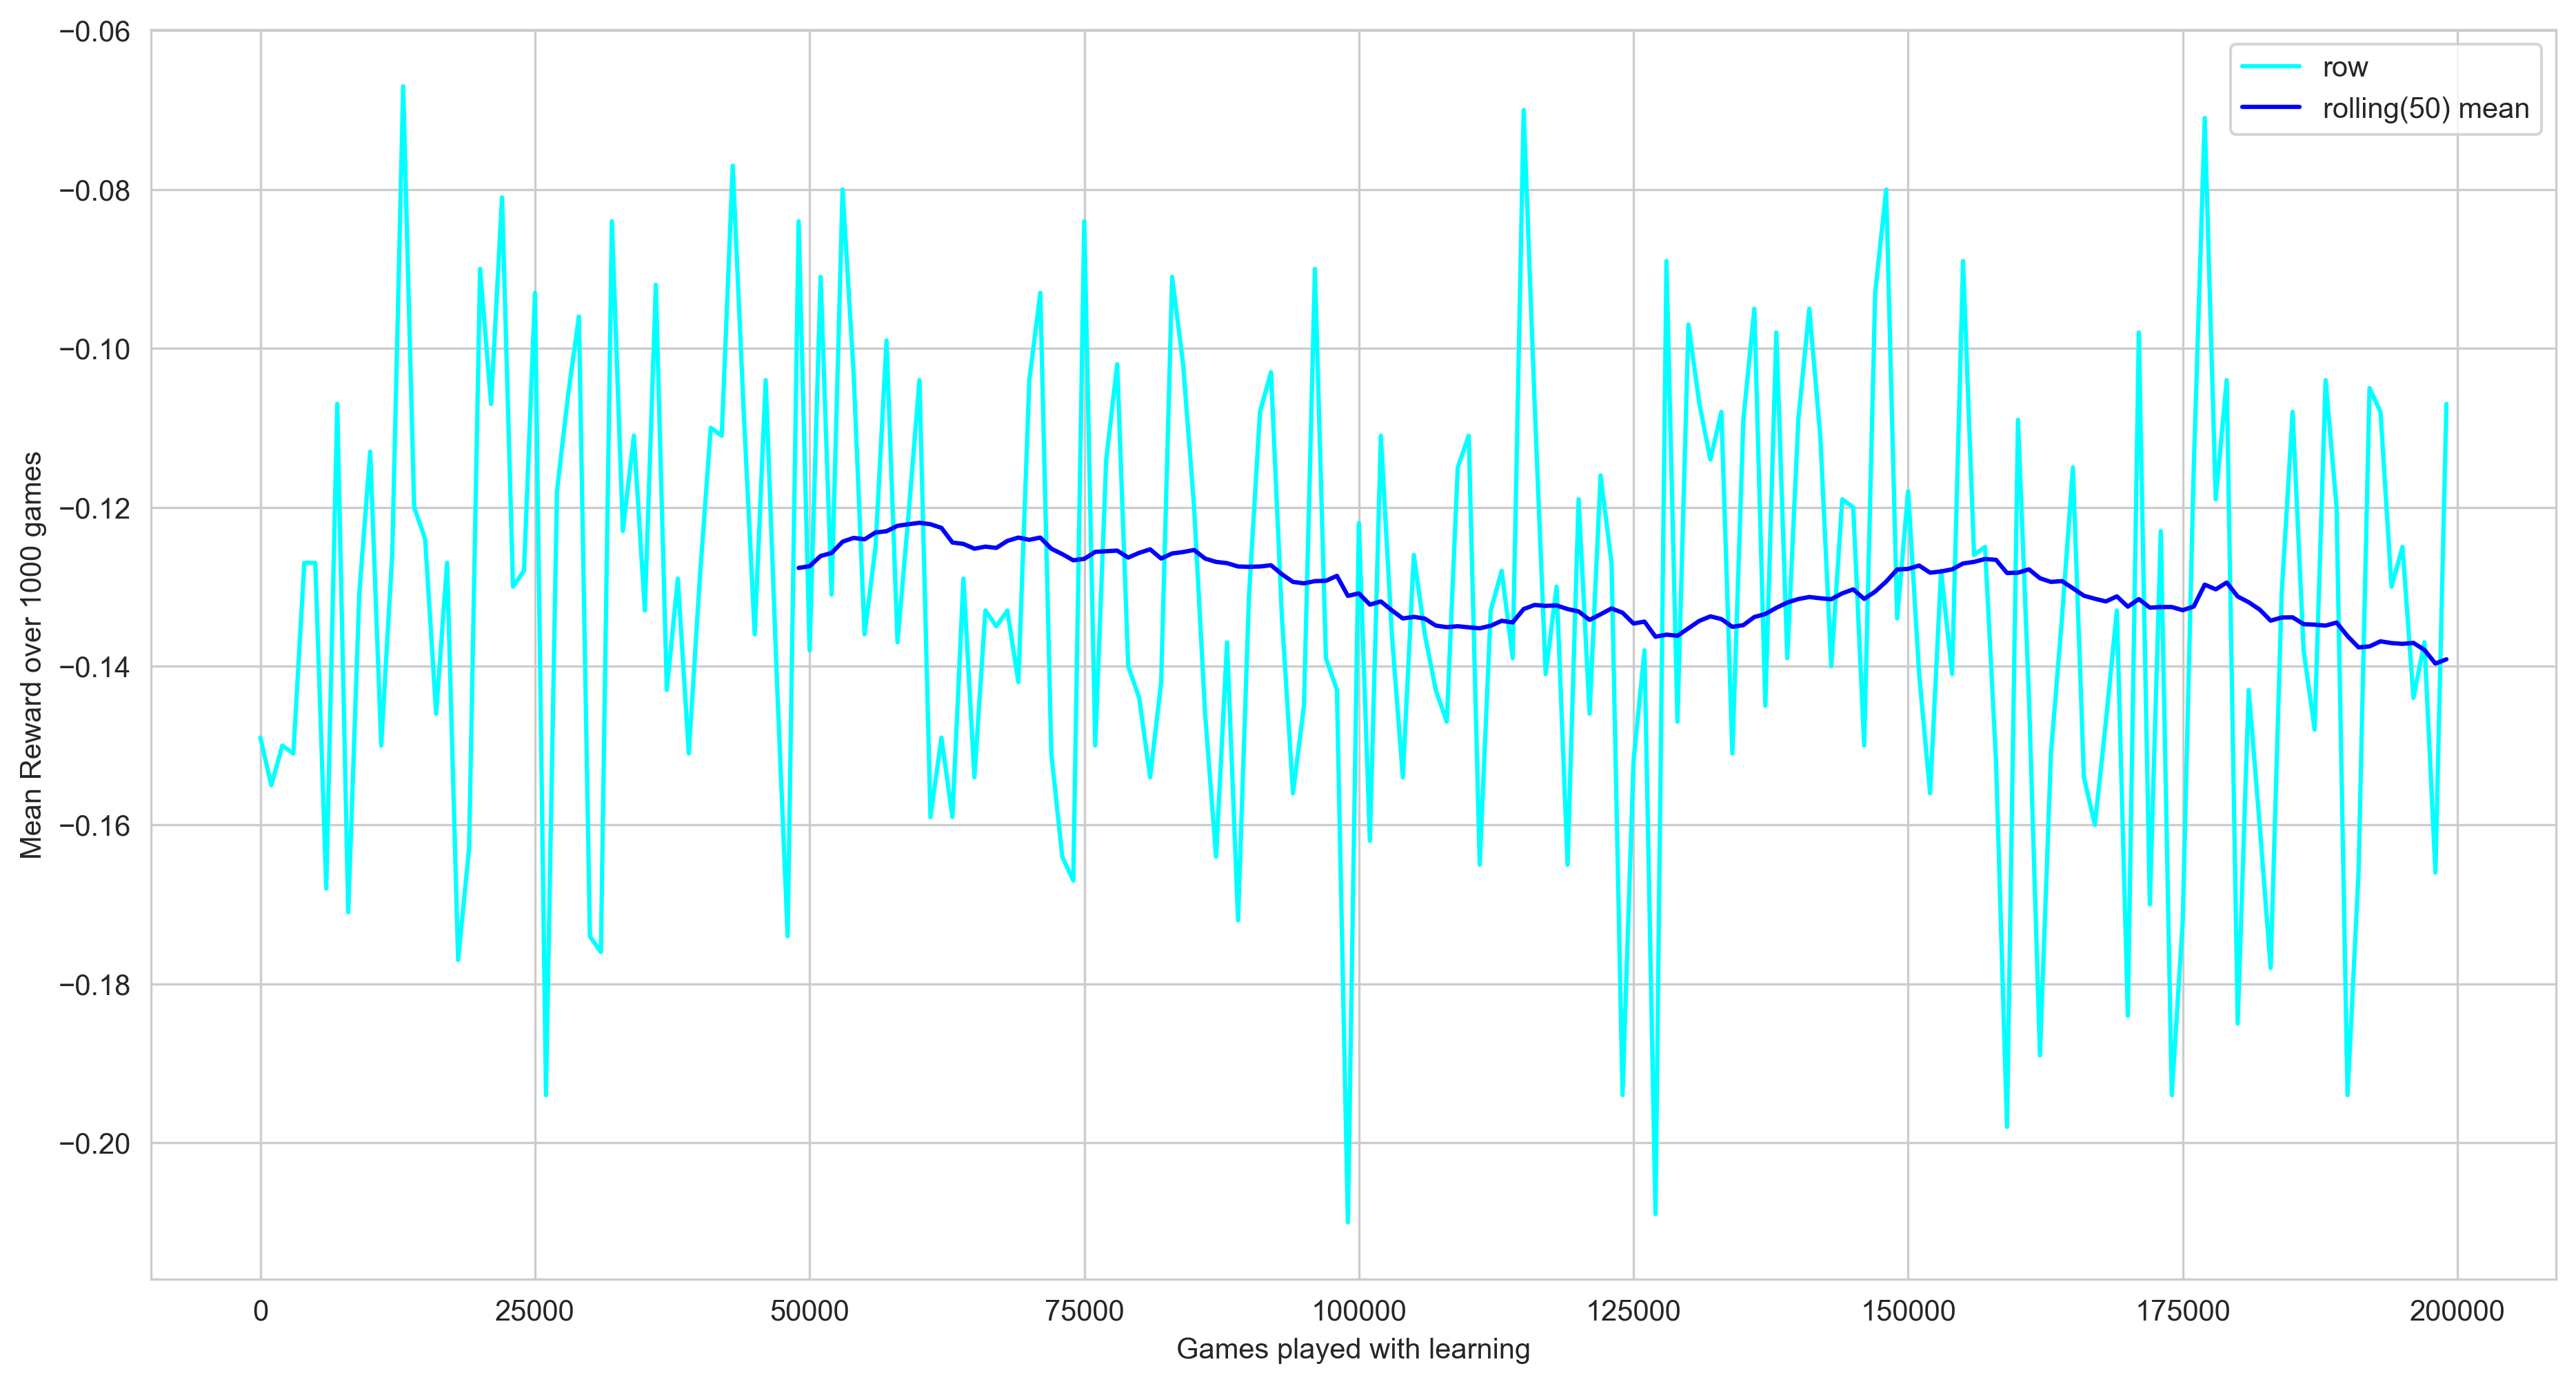

Final agent got mean reward -0.154 for 10000 games


In [31]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
gamma = 1
eps = 0.2
alpha = 0.1

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [62]:
def optuna_reward_Q_learning(trial): 
    eps = trial.suggest_uniform("eps", 0, 1)
    alpha = trial.suggest_uniform("alpha", 0, 1)
    
    agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

    env = gym.make('Blackjack-v1', natural=True)

    # env._max_episode_steps = 10000
    total_episodes = 100_000
    games_check = 10_000
    period = 1e10
    gamma = 1
#     eps = 0.2

    agent, _ = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=period)
    
#     Q = Q_learn(epsilon=epsilon, alpha=alpha, n_episods=100000, leave=False)
    res = np.mean(sample_games(agent, num_games=games_check, env=env))
    env.close()
    return res

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(optuna_reward_Q_learning, n_trials=100)

[I 2021-10-24 15:00:16,195] A new study created in memory with name: no-name-6cee6f69-2939-4f0a-8d66-48c3bac5d5c9


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:00:21,856] Trial 0 finished with value: -0.1649 and parameters: {'eps': 0.2784032308130334, 'alpha': 0.47327842668932374}. Best is trial 0 with value: -0.1649.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:00:27,062] Trial 1 finished with value: -0.1581 and parameters: {'eps': 0.9251268168900538, 'alpha': 0.5036598595060262}. Best is trial 1 with value: -0.1581.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:00:33,067] Trial 2 finished with value: -0.1335 and parameters: {'eps': 0.1015567900383485, 'alpha': 0.1725979828851426}. Best is trial 2 with value: -0.1335.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:00:39,019] Trial 3 finished with value: -0.1366 and parameters: {'eps': 0.07832241913190863, 'alpha': 0.12634109179664288}. Best is trial 2 with value: -0.1335.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:00:45,123] Trial 4 finished with value: -0.1459 and parameters: {'eps': 0.33820538354041385, 'alpha': 0.07342951994000024}. Best is trial 2 with value: -0.1335.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:00:51,161] Trial 5 finished with value: -0.1247 and parameters: {'eps': 0.7766713832613971, 'alpha': 0.18799566618730346}. Best is trial 5 with value: -0.1247.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:00:56,904] Trial 6 finished with value: -0.1085 and parameters: {'eps': 0.48265358802126435, 'alpha': 0.1529033388126838}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:02,788] Trial 7 finished with value: -0.1286 and parameters: {'eps': 0.460443101306526, 'alpha': 0.3626129468349554}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:08,472] Trial 8 finished with value: -0.1648 and parameters: {'eps': 0.1934443666394099, 'alpha': 0.9278651733045491}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:14,097] Trial 9 finished with value: -0.1493 and parameters: {'eps': 0.11529066764113038, 'alpha': 0.5016297888152437}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:19,650] Trial 10 finished with value: -0.1661 and parameters: {'eps': 0.6545649814352328, 'alpha': 0.7836377391504944}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:25,758] Trial 11 finished with value: -0.1309 and parameters: {'eps': 0.7164443511736847, 'alpha': 0.2748898108161901}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:31,894] Trial 12 finished with value: -0.1619 and parameters: {'eps': 0.6809831326517115, 'alpha': 0.010504662305404505}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:37,661] Trial 13 finished with value: -0.1361 and parameters: {'eps': 0.9518324348650322, 'alpha': 0.2799890442021378}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:42,855] Trial 14 finished with value: -0.1619 and parameters: {'eps': 0.5228875959961526, 'alpha': 0.6449246493811405}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:48,875] Trial 15 finished with value: -0.1489 and parameters: {'eps': 0.787874200837769, 'alpha': 0.2163273382114425}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:01:54,718] Trial 16 finished with value: -0.1482 and parameters: {'eps': 0.522540597666614, 'alpha': 0.34382352937271626}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:00,642] Trial 17 finished with value: -0.1523 and parameters: {'eps': 0.8371249707107163, 'alpha': 0.049558267853777066}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:06,370] Trial 18 finished with value: -0.1622 and parameters: {'eps': 0.4262291021467387, 'alpha': 0.43078067934412084}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:11,586] Trial 19 finished with value: -0.1598 and parameters: {'eps': 0.6172091295373305, 'alpha': 0.6238736857723461}. Best is trial 6 with value: -0.1085.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:17,288] Trial 20 finished with value: -0.1014 and parameters: {'eps': 0.8307968658521399, 'alpha': 0.17136665933614884}. Best is trial 20 with value: -0.1014.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:23,339] Trial 21 finished with value: -0.1704 and parameters: {'eps': 0.8441273317830312, 'alpha': 0.18578004823231006}. Best is trial 20 with value: -0.1014.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:29,162] Trial 22 finished with value: -0.1645 and parameters: {'eps': 0.578658708648651, 'alpha': 0.23181338369361468}. Best is trial 20 with value: -0.1014.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:34,845] Trial 23 finished with value: -0.1395 and parameters: {'eps': 0.7552605983054714, 'alpha': 0.1186756768513948}. Best is trial 20 with value: -0.1014.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:40,786] Trial 24 finished with value: -0.1509 and parameters: {'eps': 0.3845367138322328, 'alpha': 0.34710518137839713}. Best is trial 20 with value: -0.1014.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:47,037] Trial 25 finished with value: -0.0817 and parameters: {'eps': 0.9175039519991233, 'alpha': 0.002608295557609386}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:53,042] Trial 26 finished with value: -0.0849 and parameters: {'eps': 0.9038551766613048, 'alpha': 0.005489860864587109}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:02:59,213] Trial 27 finished with value: -0.1877 and parameters: {'eps': 0.9801692813923226, 'alpha': 0.021024670981932555}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:05,515] Trial 28 finished with value: -0.1403 and parameters: {'eps': 0.8842623995604831, 'alpha': 0.07314328170607211}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:11,540] Trial 29 finished with value: -0.1804 and parameters: {'eps': 0.9966872231341513, 'alpha': 0.01177584167744744}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:17,531] Trial 30 finished with value: -0.1219 and parameters: {'eps': 0.88830897035608, 'alpha': 0.10553312222842023}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:23,530] Trial 31 finished with value: -0.1225 and parameters: {'eps': 0.28191366028644127, 'alpha': 0.1284495642671698}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:29,383] Trial 32 finished with value: -0.0927 and parameters: {'eps': 0.9136960755811975, 'alpha': 0.004177150910744276}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:35,323] Trial 33 finished with value: -0.0857 and parameters: {'eps': 0.8970060388795631, 'alpha': 0.001462323857201697}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:41,019] Trial 34 finished with value: -0.1391 and parameters: {'eps': 0.9102525375647395, 'alpha': 0.008967267053635236}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:46,961] Trial 35 finished with value: -0.1624 and parameters: {'eps': 0.9252614341888479, 'alpha': 0.08578454519130048}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:52,801] Trial 36 finished with value: -0.1633 and parameters: {'eps': 0.7196834394387244, 'alpha': 0.07309125912203826}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:03:58,534] Trial 37 finished with value: -0.1753 and parameters: {'eps': 0.8187817606979161, 'alpha': 0.5878094372663638}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:04,788] Trial 38 finished with value: -0.1313 and parameters: {'eps': 0.8790652659141132, 'alpha': 0.13510315692766423}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:10,813] Trial 39 finished with value: -0.1681 and parameters: {'eps': 0.9328085991828856, 'alpha': 0.9851629168043321}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:16,991] Trial 40 finished with value: -0.15 and parameters: {'eps': 0.9933343261717906, 'alpha': 0.25131925443676134}. Best is trial 25 with value: -0.0817.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:23,286] Trial 41 finished with value: -0.0404 and parameters: {'eps': 0.8113359381985931, 'alpha': 0.00025419150460079774}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:29,735] Trial 42 finished with value: -0.1514 and parameters: {'eps': 0.7739949308763094, 'alpha': 0.040653391914465827}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:35,920] Trial 43 finished with value: -0.1512 and parameters: {'eps': 0.8614817347189782, 'alpha': 0.06985651836134611}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:41,866] Trial 44 finished with value: -0.0853 and parameters: {'eps': 0.9440113444825231, 'alpha': 0.0038170433909952978}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:47,662] Trial 45 finished with value: -0.1179 and parameters: {'eps': 0.956586236359125, 'alpha': 0.1554767920705624}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:53,304] Trial 46 finished with value: -0.1883 and parameters: {'eps': 0.7944223027743627, 'alpha': 0.8235508594524164}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:04:58,888] Trial 47 finished with value: -0.1134 and parameters: {'eps': 0.7423485641624469, 'alpha': 0.10134139855771705}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:04,748] Trial 48 finished with value: -0.1309 and parameters: {'eps': 0.9549342440507913, 'alpha': 0.04950105211389835}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:10,276] Trial 49 finished with value: -0.1404 and parameters: {'eps': 0.702097013897747, 'alpha': 0.3120652845307406}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:15,538] Trial 50 finished with value: -0.1409 and parameters: {'eps': 0.8164450000254025, 'alpha': 0.4208547448135228}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:21,021] Trial 51 finished with value: -0.0911 and parameters: {'eps': 0.9084862869888792, 'alpha': 0.0021169208747870982}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:26,481] Trial 52 finished with value: -0.0977 and parameters: {'eps': 0.006073240102351718, 'alpha': 0.002517484481969744}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:32,559] Trial 53 finished with value: -0.1352 and parameters: {'eps': 0.863056450940018, 'alpha': 0.04569196045217687}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:38,786] Trial 54 finished with value: -0.145 and parameters: {'eps': 0.9120004334704663, 'alpha': 0.20336639660243055}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:44,676] Trial 55 finished with value: -0.1183 and parameters: {'eps': 0.9674219294774736, 'alpha': 0.09925360280663142}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:50,805] Trial 56 finished with value: -0.158 and parameters: {'eps': 0.6535138653105703, 'alpha': 0.05277609231287826}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:05:56,473] Trial 57 finished with value: -0.0951 and parameters: {'eps': 0.7921946028901918, 'alpha': 0.16413956765413215}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:02,319] Trial 58 finished with value: -0.1336 and parameters: {'eps': 0.860609522850443, 'alpha': 0.03945580184009963}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:08,179] Trial 59 finished with value: -0.1101 and parameters: {'eps': 0.9420486874490045, 'alpha': 0.1350784676857708}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:14,311] Trial 60 finished with value: -0.1507 and parameters: {'eps': 0.8884130458852888, 'alpha': 0.10435907254069404}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:20,386] Trial 61 finished with value: -0.0762 and parameters: {'eps': 0.9087448426899213, 'alpha': 3.206592482818795e-05}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:26,727] Trial 62 finished with value: -0.1534 and parameters: {'eps': 0.8314197820064884, 'alpha': 0.044389360394113994}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:32,389] Trial 63 finished with value: -0.1425 and parameters: {'eps': 0.9056679134055662, 'alpha': 0.006141537477040066}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:38,242] Trial 64 finished with value: -0.1306 and parameters: {'eps': 0.9932986642720373, 'alpha': 0.08655628004079252}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:43,671] Trial 65 finished with value: -0.1517 and parameters: {'eps': 0.9424703831271068, 'alpha': 0.5426306046202024}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:49,414] Trial 66 finished with value: -0.0979 and parameters: {'eps': 0.8490755974035957, 'alpha': 0.0010645919547571858}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:06:55,281] Trial 67 finished with value: -0.1465 and parameters: {'eps': 0.20249146380932687, 'alpha': 0.03345979629205014}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:01,134] Trial 68 finished with value: -0.1069 and parameters: {'eps': 0.9652126068909413, 'alpha': 0.07750129531311493}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:06,698] Trial 69 finished with value: -0.1348 and parameters: {'eps': 0.759677318090392, 'alpha': 0.1830220950098718}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:12,466] Trial 70 finished with value: -0.1734 and parameters: {'eps': 0.8920779820680824, 'alpha': 0.06439924228927829}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:18,447] Trial 71 finished with value: -0.1414 and parameters: {'eps': 0.9234328996418311, 'alpha': 0.016871453937451944}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:24,356] Trial 72 finished with value: -0.1495 and parameters: {'eps': 0.8193913185196574, 'alpha': 0.032460013506473345}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:30,114] Trial 73 finished with value: -0.191 and parameters: {'eps': 0.9220713112588517, 'alpha': 0.7452890913506413}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:36,488] Trial 74 finished with value: -0.144 and parameters: {'eps': 0.881475959492857, 'alpha': 0.12845374327018622}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:42,693] Trial 75 finished with value: -0.0954 and parameters: {'eps': 0.9989442391599697, 'alpha': 0.0033828972608124924}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:48,575] Trial 76 finished with value: -0.16 and parameters: {'eps': 0.5649048633812661, 'alpha': 0.0702675826302011}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:07:54,340] Trial 77 finished with value: -0.1531 and parameters: {'eps': 0.9643594613390056, 'alpha': 0.02766737410904991}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:00,331] Trial 78 finished with value: -0.1196 and parameters: {'eps': 0.8595143388970772, 'alpha': 0.111743400332869}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:06,070] Trial 79 finished with value: -0.1445 and parameters: {'eps': 0.8088430007052917, 'alpha': 0.06498389196416837}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:11,769] Trial 80 finished with value: -0.136 and parameters: {'eps': 0.9024733552575401, 'alpha': 0.1482970358730164}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:17,829] Trial 81 finished with value: -0.1637 and parameters: {'eps': 0.7719460572774188, 'alpha': 0.025427712585520866}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:23,586] Trial 82 finished with value: -0.1632 and parameters: {'eps': 0.7962583636057003, 'alpha': 0.15401220815767355}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:29,153] Trial 83 finished with value: -0.0954 and parameters: {'eps': 0.7283847194775681, 'alpha': 0.00040743762267267977}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:34,719] Trial 84 finished with value: -0.1433 and parameters: {'eps': 0.9364779815951726, 'alpha': 0.0884176633958256}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:40,515] Trial 85 finished with value: -0.1217 and parameters: {'eps': 0.8408390630406923, 'alpha': 0.04373502605999342}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:46,007] Trial 86 finished with value: -0.1475 and parameters: {'eps': 0.8702202004719843, 'alpha': 0.3967742543814643}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:51,648] Trial 87 finished with value: -0.1213 and parameters: {'eps': 0.9018477603439663, 'alpha': 0.22848576536490128}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:08:57,463] Trial 88 finished with value: -0.1241 and parameters: {'eps': 0.6859336979303141, 'alpha': 0.0619952878294821}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:03,421] Trial 89 finished with value: -0.134 and parameters: {'eps': 0.970458669853049, 'alpha': 0.023009417442817703}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:09,203] Trial 90 finished with value: -0.1346 and parameters: {'eps': 0.7909397012221178, 'alpha': 0.1059079835230619}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:14,972] Trial 91 finished with value: -0.0845 and parameters: {'eps': 0.9978183893311576, 'alpha': 0.0008317636202136275}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:21,009] Trial 92 finished with value: -0.1821 and parameters: {'eps': 0.9495012859150265, 'alpha': 0.027139012761670994}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:27,006] Trial 93 finished with value: -0.1478 and parameters: {'eps': 0.9183263285794709, 'alpha': 0.05987339708913606}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:33,124] Trial 94 finished with value: -0.1577 and parameters: {'eps': 0.9847203317687406, 'alpha': 0.0872575382097813}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:39,633] Trial 95 finished with value: -0.1676 and parameters: {'eps': 0.8764865294951126, 'alpha': 0.023174569984881245}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:46,034] Trial 96 finished with value: -0.1396 and parameters: {'eps': 0.9324252670944871, 'alpha': 0.03722024059442346}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:51,848] Trial 97 finished with value: -0.0925 and parameters: {'eps': 0.8397893616096751, 'alpha': 0.0036173860832095913}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:09:57,493] Trial 98 finished with value: -0.1474 and parameters: {'eps': 0.8393358242116282, 'alpha': 0.05522312055361574}. Best is trial 41 with value: -0.0404.


  0%|          | 0/50000 [00:00<?, ?it/s]

[I 2021-10-24 15:10:02,957] Trial 99 finished with value: -0.0775 and parameters: {'eps': 0.42683421487085205, 'alpha': 0.0012335441494280629}. Best is trial 41 with value: -0.0404.


  0%|          | 0/200000 [00:00<?, ?it/s]

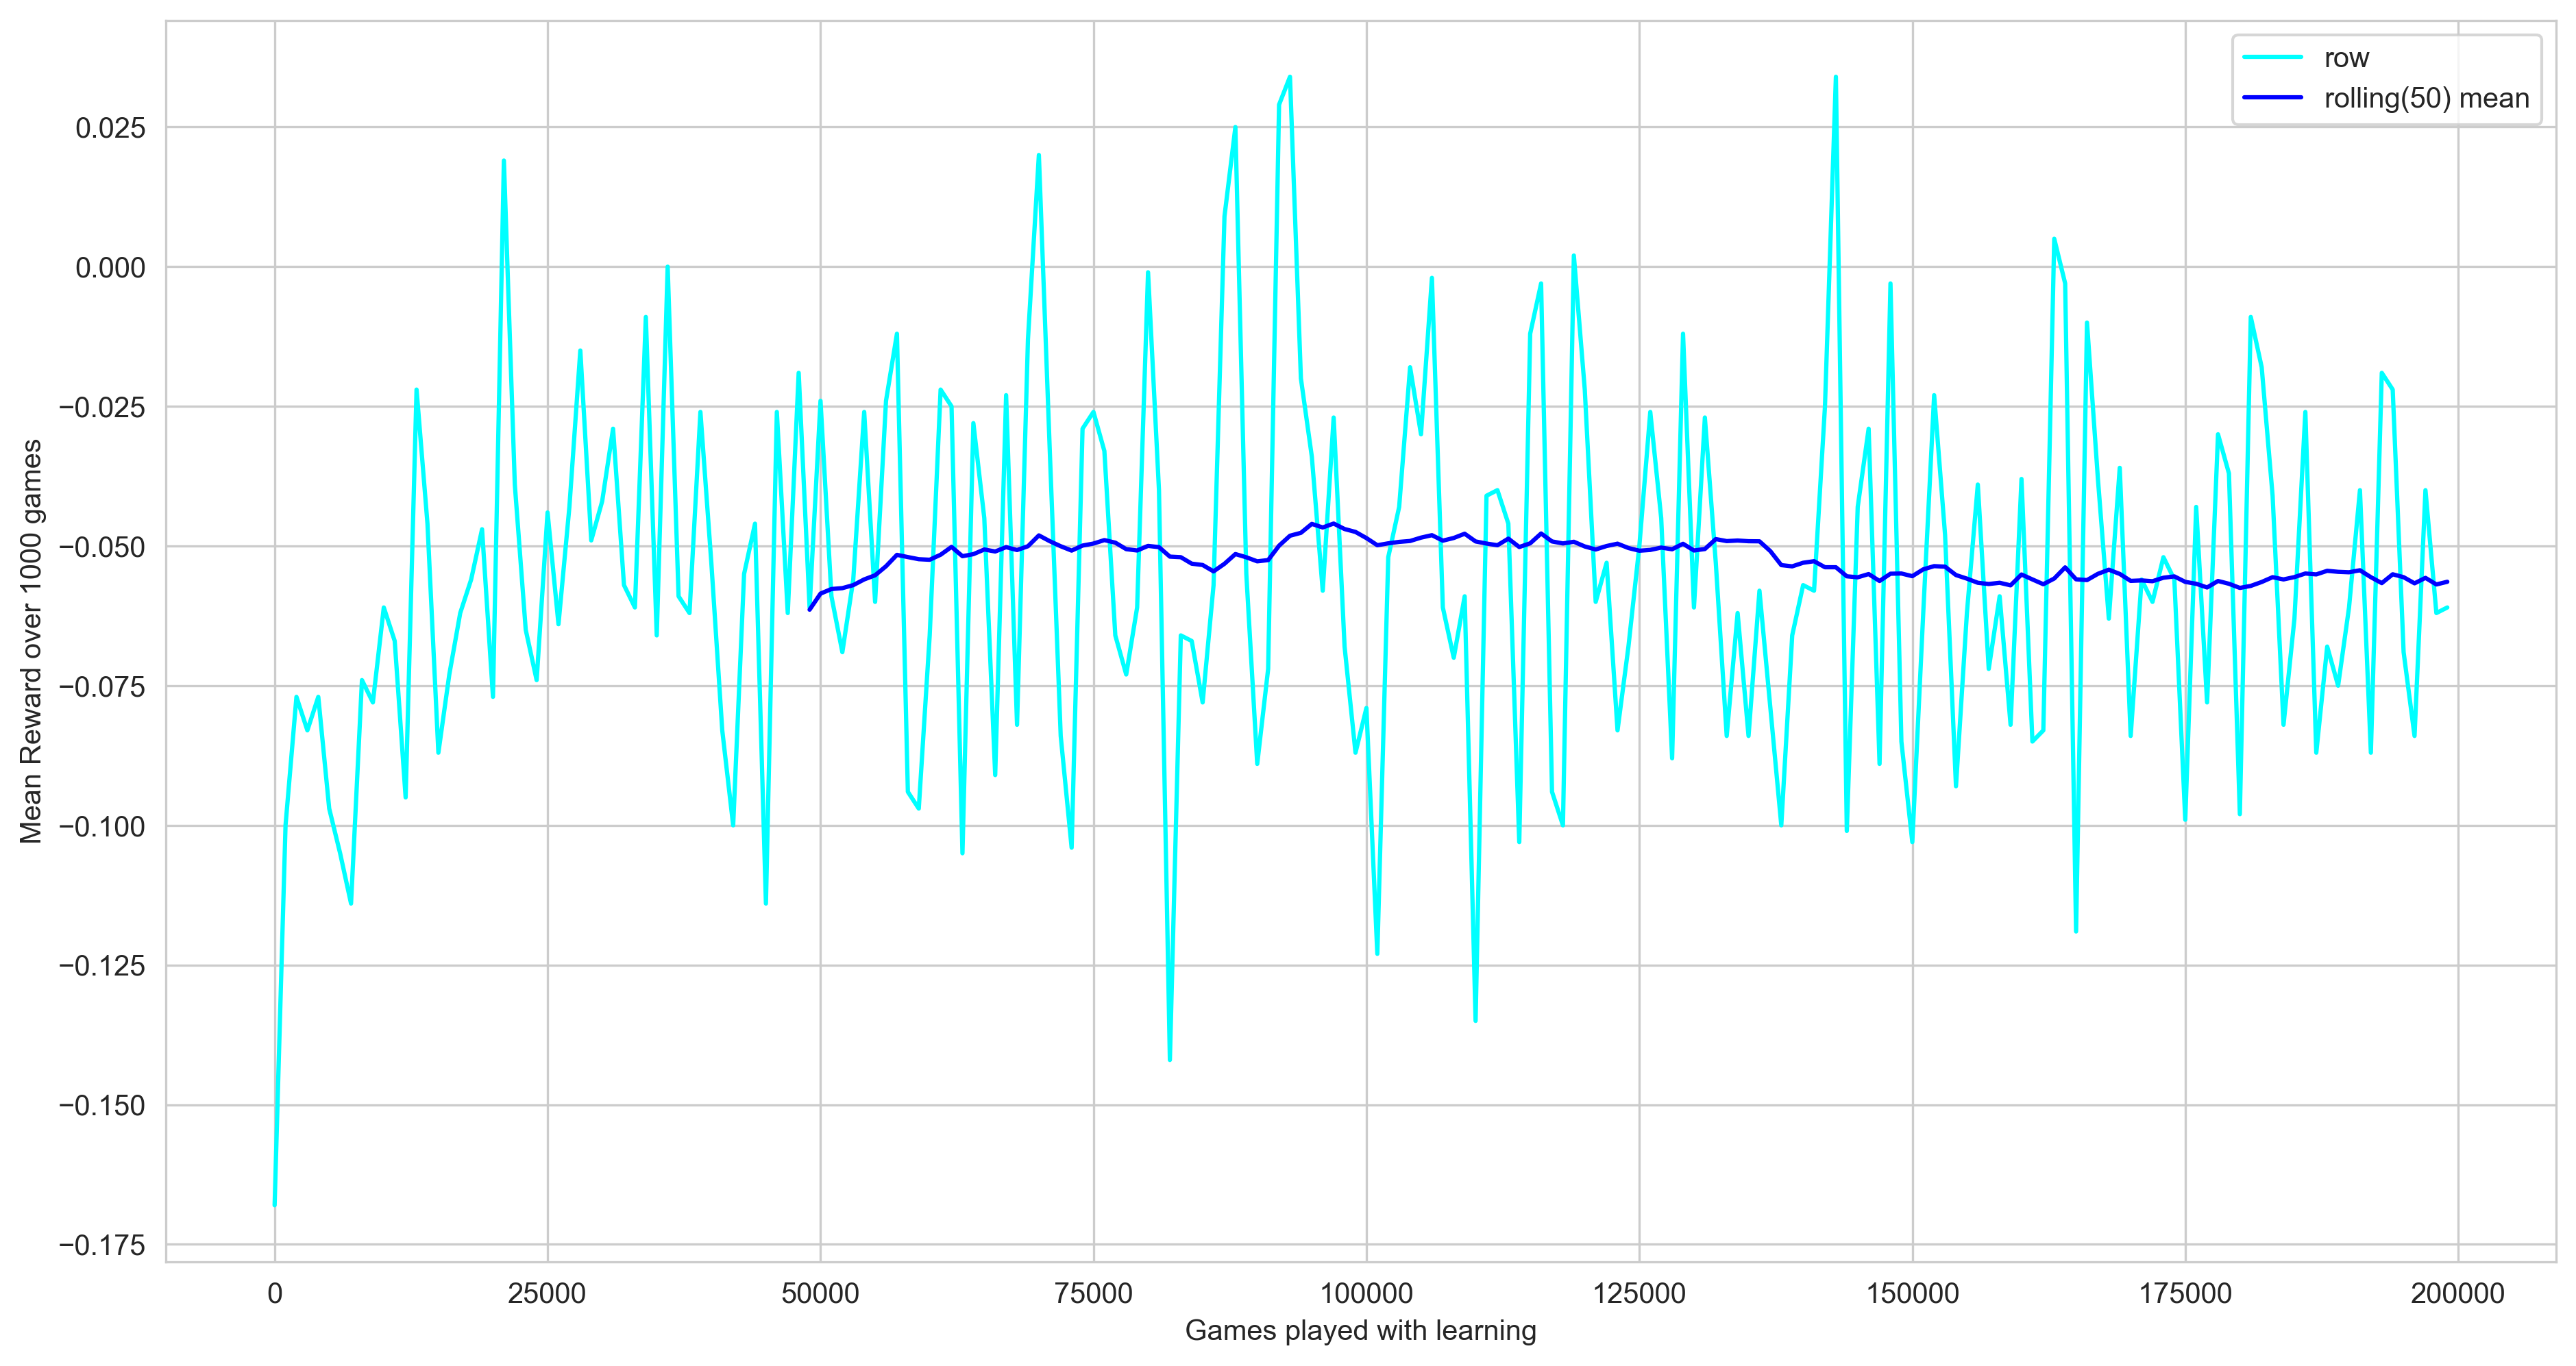

Final agent got mean reward -0.058 for 10000 games


In [42]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
gamma = 1
eps = study.best_params["eps"]
alpha = study.best_params["alpha"]

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=salpha,
                                      n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится.
Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными,
а на самом деле у игрока есть ещё и другие возможности. Реализовывать __split__ может оказаться непросто,
поэтому давайте ограничимся удвоением ставки.  
Итак, у игрока появляется дополнительное действие:  
- __double__ — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [43]:
from BlackJackDouble import BlackjackDoubleEnv
env = BlackjackDoubleEnv(natural=True, double=True)

In [44]:
# example
print(env.reset())
print(env.step(2))

(14, 10, False)
((24, 10, False), -2.0, True, {})


### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [45]:
# constants
nA = 3
nS = 380

In [46]:
for _ in range(10):
    env = BlackjackDoubleEnv(natural=True, double=True)
    states = collect_states(env, NUM_GAMES=30_000)
    if len(states) == nS:
        break
len(states)

380

In [47]:
state_list = list(states)
state_to_idx = {s: i for i, s in enumerate(state_list)}
idx_to_state = {i: s for i, s in enumerate(state_list)}

  0%|          | 0/200000 [00:00<?, ?it/s]

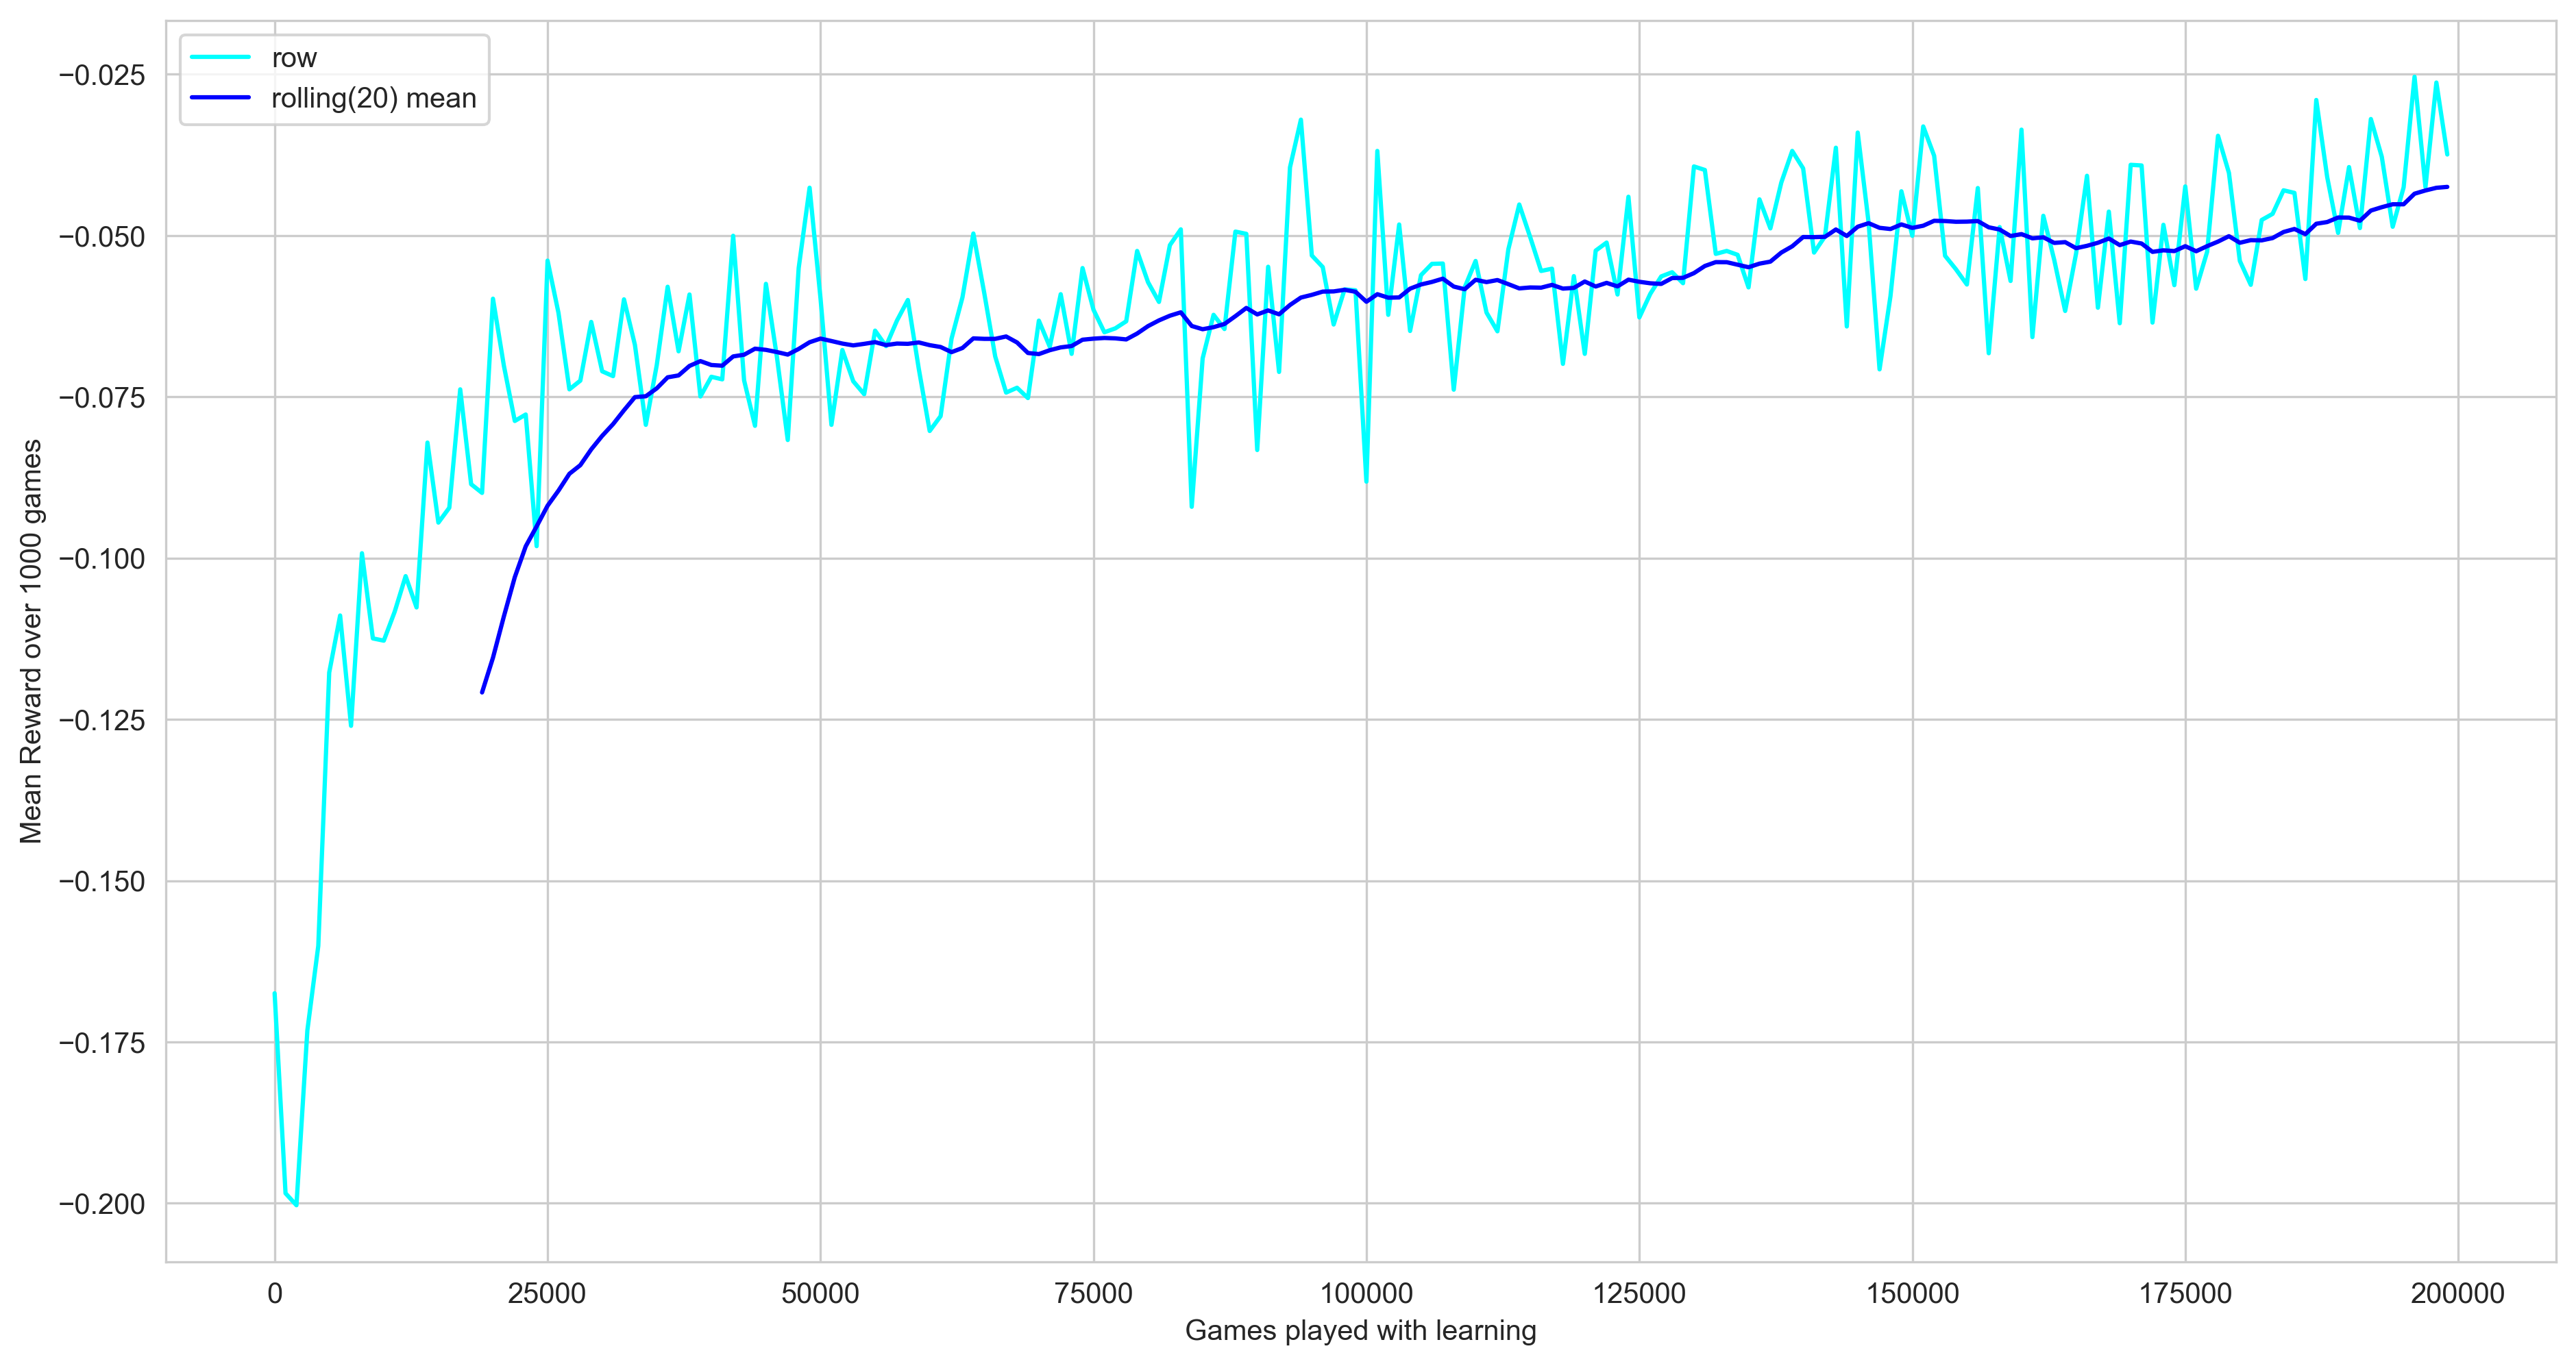

Final agent got mean reward -0.054 for 10000 games


In [54]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.5

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards_rolling(reward_list, period=n_check, roll=20)

res = np.mean(sample_games(agent, num_games=num_games, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

  0%|          | 0/400000 [00:00<?, ?it/s]

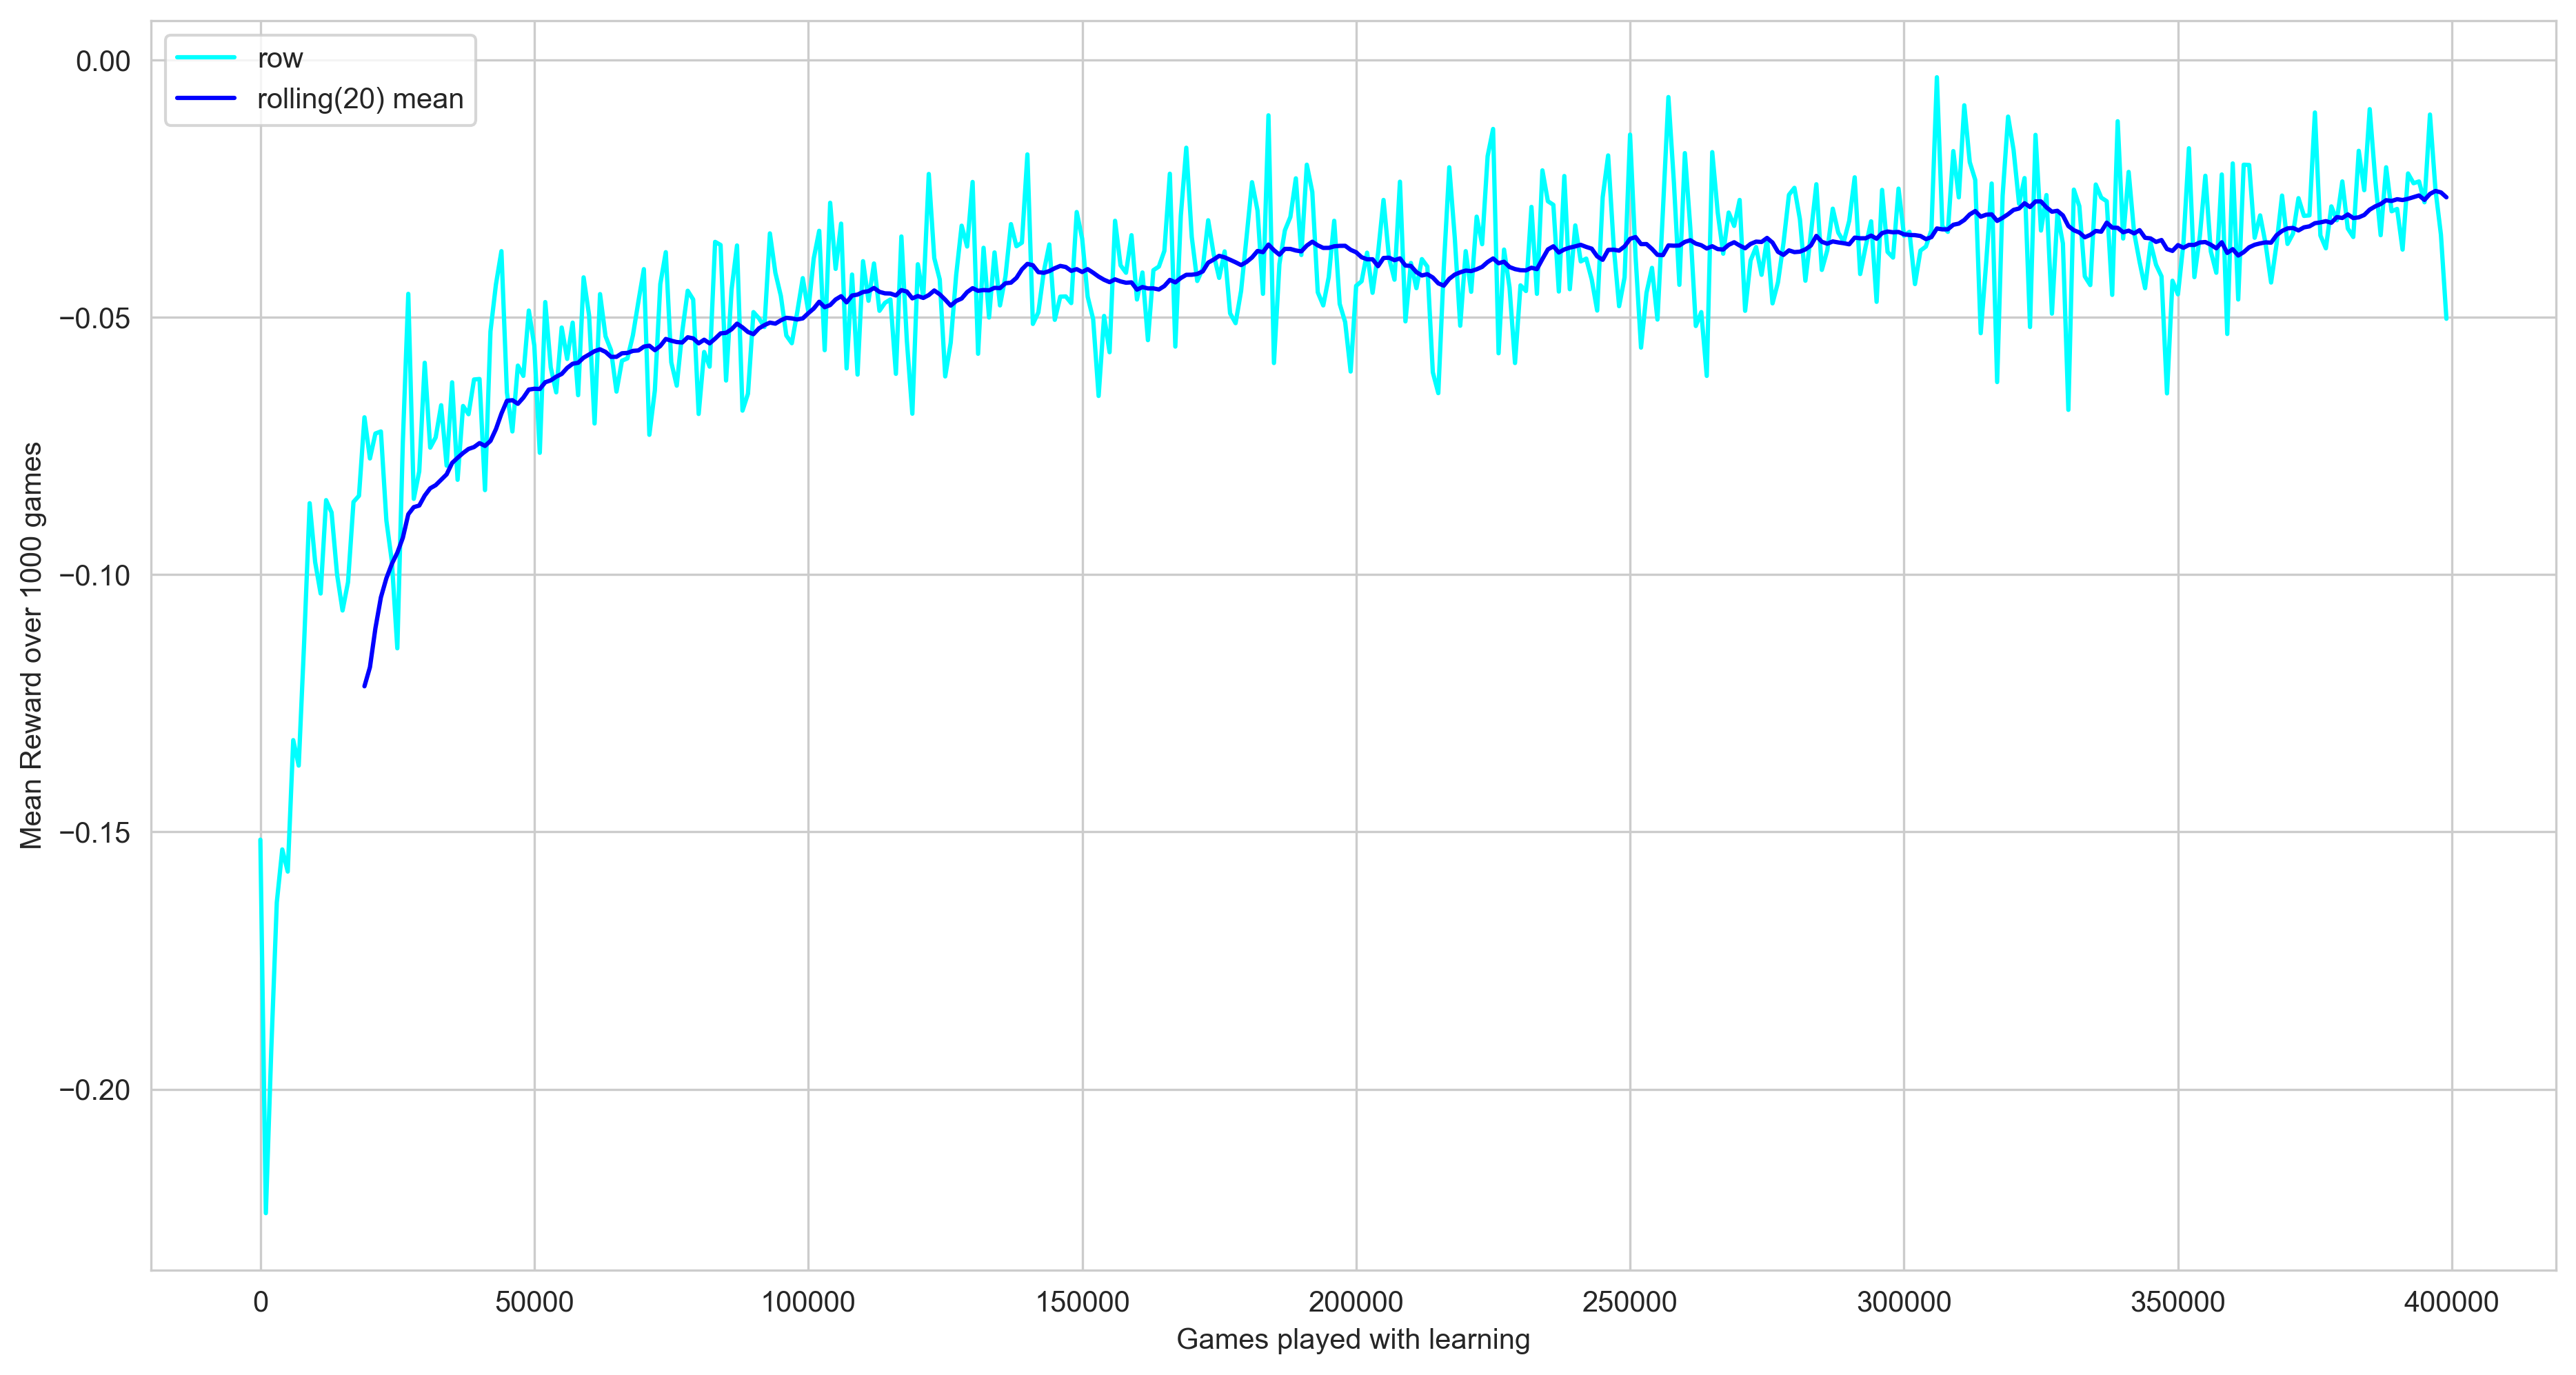

Final agent got mean reward -0.019 for 10000 games


In [55]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 400_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.5

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards_rolling(reward_list, period=n_check, roll=20)

res = np.mean(sample_games(agent, num_games=num_games, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

  0%|          | 0/100000 [00:00<?, ?it/s]

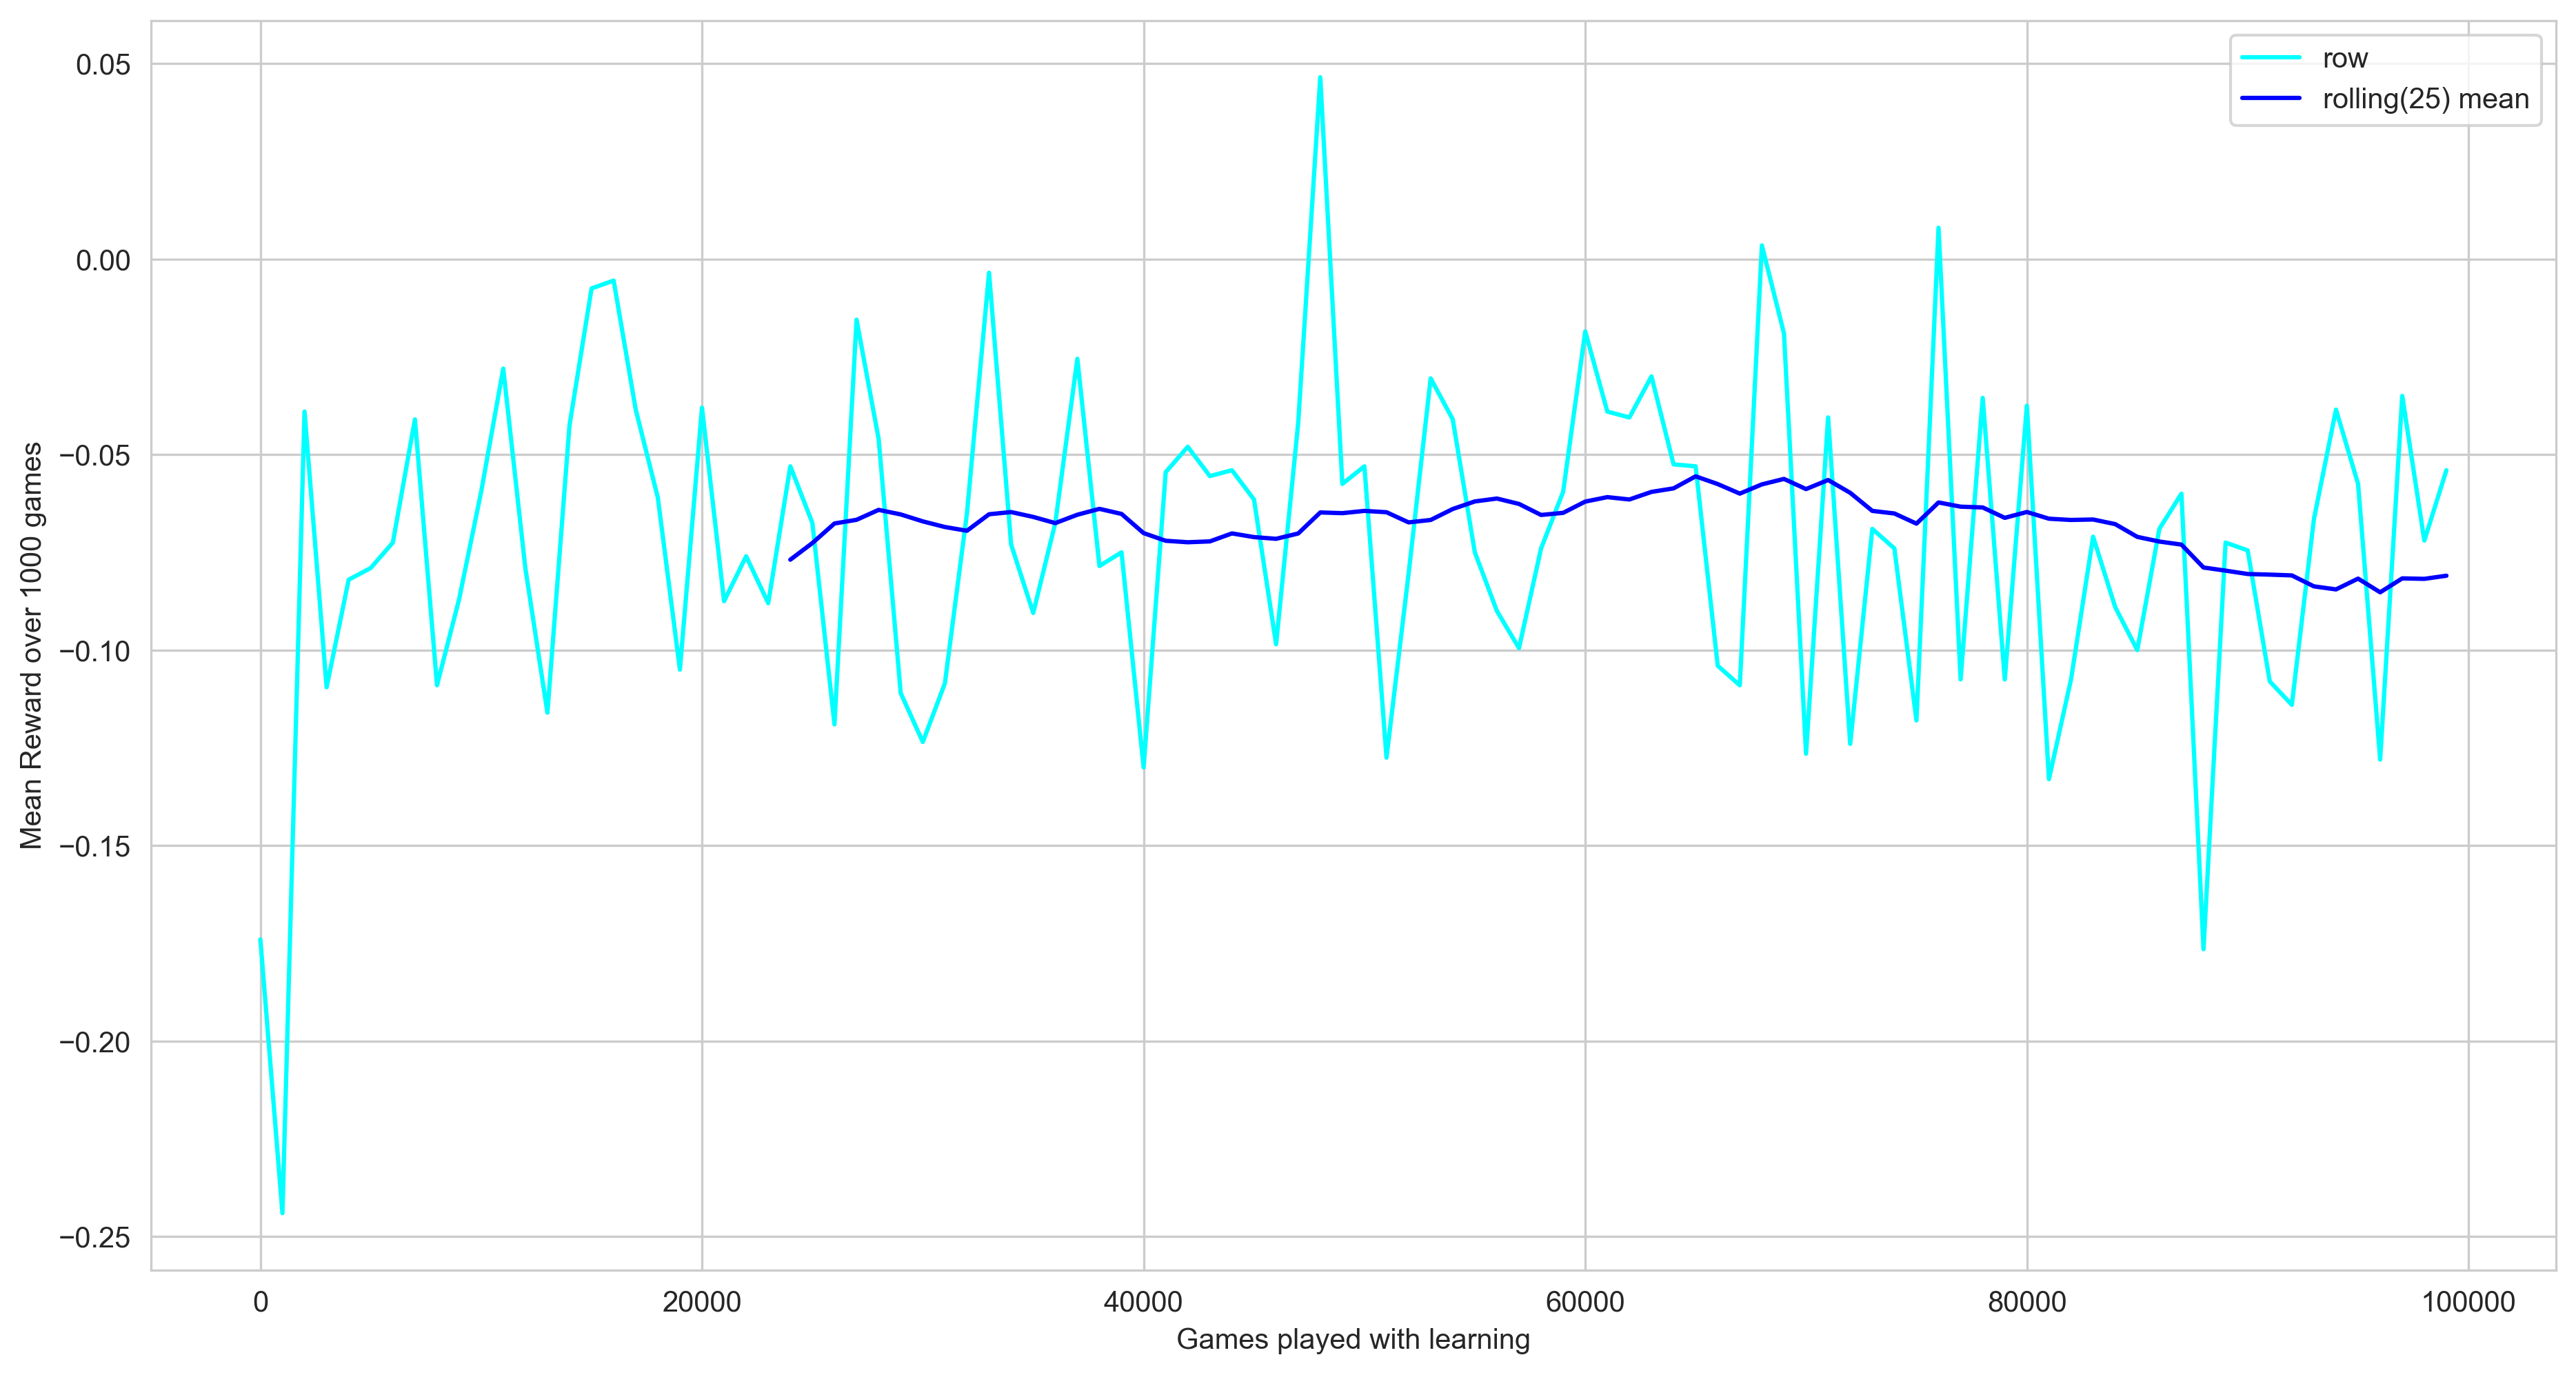

Final agent got mean reward -0.092 for 10000 games


In [60]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
gamma = 1
eps = 0.95
alpha = 0.01

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=25)

res = np.mean(sample_games(agent, num_games=num_games_outer, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [63]:
def optuna_reward_Q_learning(trial): 
    eps = trial.suggest_uniform("eps", 0, 1)
    alpha = trial.suggest_uniform("alpha", 0, 1)
    
    agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

    env = BlackjackDoubleEnv(natural=True, double=True)

    # env._max_episode_steps = 10000
    total_episodes = 100_000
    games_check = 10_000
    period = 1e10
    gamma = 1
#     eps = 0.2

    agent, _ = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=period)
    
#     Q = Q_learn(epsilon=epsilon, alpha=alpha, n_episods=100000, leave=False)
    res = np.mean(sample_games(agent, num_games=games_check, env=env))
    env.close()
    return res

In [64]:
study = optuna.create_study(direction="maximize")
study.optimize(optuna_reward_Q_learning, n_trials=100)

[I 2021-10-24 15:38:04,932] A new study created in memory with name: no-name-89d6fc05-2eab-4c1c-9b0a-0d151f36e288


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:38:15,044] Trial 0 finished with value: -0.1434 and parameters: {'eps': 0.07832312739926339, 'alpha': 0.6992397504398579}. Best is trial 0 with value: -0.1434.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:38:25,984] Trial 1 finished with value: -0.15215 and parameters: {'eps': 0.5197382366096892, 'alpha': 0.1934136867233871}. Best is trial 0 with value: -0.1434.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:38:37,022] Trial 2 finished with value: -0.18155 and parameters: {'eps': 0.5823300145237663, 'alpha': 0.35571258399136185}. Best is trial 0 with value: -0.1434.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:38:47,461] Trial 3 finished with value: -0.201 and parameters: {'eps': 0.36208726329355767, 'alpha': 0.7204331866906754}. Best is trial 0 with value: -0.1434.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:38:57,444] Trial 4 finished with value: -0.20645 and parameters: {'eps': 0.49027041262837734, 'alpha': 0.022069724705097826}. Best is trial 0 with value: -0.1434.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:39:07,333] Trial 5 finished with value: -0.16045 and parameters: {'eps': 0.5459715257034066, 'alpha': 0.5830065098947832}. Best is trial 0 with value: -0.1434.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:39:16,930] Trial 6 finished with value: -0.168 and parameters: {'eps': 0.35131178684696684, 'alpha': 0.8982408750113843}. Best is trial 0 with value: -0.1434.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:39:26,987] Trial 7 finished with value: -0.12965 and parameters: {'eps': 0.8991294404548319, 'alpha': 0.8038135925486171}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:39:36,801] Trial 8 finished with value: -0.1534 and parameters: {'eps': 0.7068345255992691, 'alpha': 0.7194350968928458}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:39:47,727] Trial 9 finished with value: -0.2038 and parameters: {'eps': 0.16111242433010864, 'alpha': 0.01639684101203498}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:39:58,253] Trial 10 finished with value: -0.15855 and parameters: {'eps': 0.9454365222299294, 'alpha': 0.9794961570584614}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:40:09,512] Trial 11 finished with value: -0.1743 and parameters: {'eps': 0.000572878944557001, 'alpha': 0.7739080597179695}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:40:20,836] Trial 12 finished with value: -0.1999 and parameters: {'eps': 0.9878200124942894, 'alpha': 0.5136187723112485}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:40:30,863] Trial 13 finished with value: -0.2023 and parameters: {'eps': 0.8142614113648318, 'alpha': 0.8274897394143053}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:40:41,523] Trial 14 finished with value: -0.1741 and parameters: {'eps': 0.16642773362374763, 'alpha': 0.618965077448698}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:40:51,594] Trial 15 finished with value: -0.1822 and parameters: {'eps': 0.7751463609608679, 'alpha': 0.40640893073367185}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:41:03,218] Trial 16 finished with value: -0.20105 and parameters: {'eps': 0.00024561745589923856, 'alpha': 0.9810412283078151}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:41:12,685] Trial 17 finished with value: -0.1512 and parameters: {'eps': 0.2768701123568782, 'alpha': 0.6449236269964717}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:41:22,438] Trial 18 finished with value: -0.21605 and parameters: {'eps': 0.8645206081939162, 'alpha': 0.8661275803735565}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:41:32,389] Trial 19 finished with value: -0.15045 and parameters: {'eps': 0.6656535732238681, 'alpha': 0.5285387230761522}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:41:42,749] Trial 20 finished with value: -0.14835 and parameters: {'eps': 0.1668609875240143, 'alpha': 0.35773591606058264}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:41:52,672] Trial 21 finished with value: -0.1654 and parameters: {'eps': 0.13071741836501446, 'alpha': 0.39549652653405554}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:42:02,788] Trial 22 finished with value: -0.1655 and parameters: {'eps': 0.27518731431179155, 'alpha': 0.30796295227631687}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:42:13,808] Trial 23 finished with value: -0.139 and parameters: {'eps': 0.07347854720858087, 'alpha': 0.1524006656380842}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:42:24,165] Trial 24 finished with value: -0.1464 and parameters: {'eps': 0.4330315412708945, 'alpha': 0.14723587524902448}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:42:34,077] Trial 25 finished with value: -0.17925 and parameters: {'eps': 0.07426906422689476, 'alpha': 0.6770587226831652}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:42:43,216] Trial 26 finished with value: -0.17925 and parameters: {'eps': 0.2685918096219091, 'alpha': 0.7850088091127014}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:42:53,475] Trial 27 finished with value: -0.17845 and parameters: {'eps': 0.09362148393639308, 'alpha': 0.23413821489067133}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:43:03,948] Trial 28 finished with value: -0.1611 and parameters: {'eps': 0.3473033832869437, 'alpha': 0.1066259045227932}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:43:13,637] Trial 29 finished with value: -0.1598 and parameters: {'eps': 0.6524668253528578, 'alpha': 0.4523796899907529}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:43:22,935] Trial 30 finished with value: -0.1727 and parameters: {'eps': 0.2312562821888479, 'alpha': 0.26172111896082095}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:43:32,468] Trial 31 finished with value: -0.1765 and parameters: {'eps': 0.44878447359724155, 'alpha': 0.15539484974875833}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:43:42,354] Trial 32 finished with value: -0.20745 and parameters: {'eps': 0.06768643446167497, 'alpha': 0.1112771787920408}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:43:52,076] Trial 33 finished with value: -0.1876 and parameters: {'eps': 0.5898484008691639, 'alpha': 0.16604133602053686}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:44:02,340] Trial 34 finished with value: -0.15555 and parameters: {'eps': 0.42870017743133726, 'alpha': 0.0856614349213272}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:44:11,667] Trial 35 finished with value: -0.15385 and parameters: {'eps': 0.21480305281422124, 'alpha': 0.5696607146810939}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:44:21,789] Trial 36 finished with value: -0.2002 and parameters: {'eps': 0.39630715762858826, 'alpha': 0.8989149393062006}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:44:32,211] Trial 37 finished with value: -0.1753 and parameters: {'eps': 0.5058027703585931, 'alpha': 0.7067691389941643}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:44:42,607] Trial 38 finished with value: -0.19775 and parameters: {'eps': 0.5703890333597252, 'alpha': 0.23273503001953852}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:44:53,071] Trial 39 finished with value: -0.18215 and parameters: {'eps': 0.31452993472984314, 'alpha': 0.05015685548815822}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:45:02,554] Trial 40 finished with value: -0.16125 and parameters: {'eps': 0.04219871272653921, 'alpha': 0.7688850834897769}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:45:13,021] Trial 41 finished with value: -0.2002 and parameters: {'eps': 0.15499224148509666, 'alpha': 0.19871753913598258}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:45:22,901] Trial 42 finished with value: -0.1943 and parameters: {'eps': 0.2016595189829964, 'alpha': 0.32081325578519365}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:45:32,398] Trial 43 finished with value: -0.20355 and parameters: {'eps': 0.11944860060535029, 'alpha': 0.31114913557123147}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:45:42,815] Trial 44 finished with value: -0.1672 and parameters: {'eps': 0.8996480291289982, 'alpha': 0.4534022112521428}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:45:52,671] Trial 45 finished with value: -0.20355 and parameters: {'eps': 0.7333044187862889, 'alpha': 0.3750153882779186}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:46:01,812] Trial 46 finished with value: -0.16535 and parameters: {'eps': 0.18244254362101664, 'alpha': 0.8977216280222591}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:46:12,273] Trial 47 finished with value: -0.13955 and parameters: {'eps': 0.04935749672482466, 'alpha': 0.050875641396277343}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:46:22,406] Trial 48 finished with value: -0.14935 and parameters: {'eps': 0.10770534292725487, 'alpha': 0.0126344859696354}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:46:33,042] Trial 49 finished with value: -0.19605 and parameters: {'eps': 0.046442488455060424, 'alpha': 0.05639797447599336}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:46:43,542] Trial 50 finished with value: -0.1451 and parameters: {'eps': 0.01966064992576, 'alpha': 0.14842664797192917}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:46:53,966] Trial 51 finished with value: -0.18035 and parameters: {'eps': 0.017492233545784622, 'alpha': 0.14898896962279162}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:47:04,706] Trial 52 finished with value: -0.1418 and parameters: {'eps': 0.038149698094876484, 'alpha': 0.07106775335177218}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:47:14,807] Trial 53 finished with value: -0.1459 and parameters: {'eps': 0.04976637125867637, 'alpha': 0.061904941034634856}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:47:25,435] Trial 54 finished with value: -0.16195 and parameters: {'eps': 0.01693968886703562, 'alpha': 0.015890184336158436}. Best is trial 7 with value: -0.12965.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:47:35,387] Trial 55 finished with value: -0.11695 and parameters: {'eps': 0.1385000818165499, 'alpha': 0.11653049148195947}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:47:46,034] Trial 56 finished with value: -0.2006 and parameters: {'eps': 0.11697151947490232, 'alpha': 0.09599080426306099}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:47:55,866] Trial 57 finished with value: -0.174 and parameters: {'eps': 0.14794359894550035, 'alpha': 0.8410046805147695}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:48:06,237] Trial 58 finished with value: -0.16265 and parameters: {'eps': 0.0993523089988871, 'alpha': 0.20045764336463998}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:48:15,970] Trial 59 finished with value: -0.1601 and parameters: {'eps': 0.07124238234737405, 'alpha': 0.746412140533777}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:48:25,810] Trial 60 finished with value: -0.1704 and parameters: {'eps': 0.97156125976953, 'alpha': 0.6220875521366999}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:48:36,692] Trial 61 finished with value: -0.1625 and parameters: {'eps': 0.005964985886404921, 'alpha': 0.13796822227471534}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:48:47,255] Trial 62 finished with value: -0.23945 and parameters: {'eps': 0.08784254782470757, 'alpha': 0.060558421080810707}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:48:56,970] Trial 63 finished with value: -0.13575 and parameters: {'eps': 0.24003144714672345, 'alpha': 0.11703013076708807}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:49:06,641] Trial 64 finished with value: -0.21385 and parameters: {'eps': 0.243251702574335, 'alpha': 0.11690730375345115}. Best is trial 55 with value: -0.11695.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:49:16,790] Trial 65 finished with value: -0.115 and parameters: {'eps': 0.15006984885918928, 'alpha': 0.0003226429892392718}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:49:27,704] Trial 66 finished with value: -0.14955 and parameters: {'eps': 0.13748849404476013, 'alpha': 0.005321034481904768}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:49:37,654] Trial 67 finished with value: -0.1765 and parameters: {'eps': 0.30637008001604693, 'alpha': 0.08295358026570807}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:49:48,149] Trial 68 finished with value: -0.19265 and parameters: {'eps': 0.17242086396013456, 'alpha': 0.04713192681331589}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:49:57,802] Trial 69 finished with value: -0.18135 and parameters: {'eps': 0.19609834174206137, 'alpha': 0.1819086035032765}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:50:07,303] Trial 70 finished with value: -0.17665 and parameters: {'eps': 0.2415110446653005, 'alpha': 0.2498898701123391}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:50:16,784] Trial 71 finished with value: -0.14545 and parameters: {'eps': 0.049841258894693145, 'alpha': 0.9562673781647003}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:50:27,770] Trial 72 finished with value: -0.17515 and parameters: {'eps': 0.08318379956666531, 'alpha': 0.03678380661822982}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:50:37,553] Trial 73 finished with value: -0.1601 and parameters: {'eps': 0.14114205316752915, 'alpha': 0.8112493364085932}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:50:47,854] Trial 74 finished with value: -0.16835 and parameters: {'eps': 0.10989792996276898, 'alpha': 0.113479803523759}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:50:57,514] Trial 75 finished with value: -0.157 and parameters: {'eps': 0.7914056718004454, 'alpha': 0.6741010808307302}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:51:07,397] Trial 76 finished with value: -0.1835 and parameters: {'eps': 0.6301796826281427, 'alpha': 0.21497458916523768}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:51:17,879] Trial 77 finished with value: -0.1956 and parameters: {'eps': 0.4757587026416342, 'alpha': 0.08643267725125996}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:51:28,750] Trial 78 finished with value: -0.156 and parameters: {'eps': 0.06772461094919144, 'alpha': 0.032763143851083656}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:51:38,210] Trial 79 finished with value: -0.16465 and parameters: {'eps': 0.21216303970841127, 'alpha': 0.5592090195110865}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:51:48,130] Trial 80 finished with value: -0.1455 and parameters: {'eps': 0.04287379798644225, 'alpha': 0.17558077216342546}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:51:57,799] Trial 81 finished with value: -0.19365 and parameters: {'eps': 0.024919788189947847, 'alpha': 0.2841639434069428}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:52:08,456] Trial 82 finished with value: -0.2333 and parameters: {'eps': 0.1297574790445436, 'alpha': 0.13241283546937418}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:52:18,928] Trial 83 finished with value: -0.18665 and parameters: {'eps': 0.17089634241728247, 'alpha': 0.07753924072400649}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:52:29,915] Trial 84 finished with value: -0.15355 and parameters: {'eps': 0.03017750613585956, 'alpha': 0.13251440211456367}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:52:40,319] Trial 85 finished with value: -0.1658 and parameters: {'eps': 0.06303401099517866, 'alpha': 0.1730185066418497}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:52:50,929] Trial 86 finished with value: -0.1228 and parameters: {'eps': 9.193678365826408e-07, 'alpha': 0.001925743016911506}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:53:01,754] Trial 87 finished with value: -0.16045 and parameters: {'eps': 0.002156064303347725, 'alpha': 0.005948324026506052}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:53:12,354] Trial 88 finished with value: -0.17125 and parameters: {'eps': 0.09256224108908459, 'alpha': 0.03189490455754175}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:53:23,035] Trial 89 finished with value: -0.1652 and parameters: {'eps': 0.5441013083072503, 'alpha': 0.08137537786736593}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:53:34,268] Trial 90 finished with value: -0.20685 and parameters: {'eps': 0.37625290648063237, 'alpha': 0.02872719613984907}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:53:45,233] Trial 91 finished with value: -0.17745 and parameters: {'eps': 0.03589361517327869, 'alpha': 0.10935514557932843}. Best is trial 65 with value: -0.115.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:53:56,087] Trial 92 finished with value: -0.1145 and parameters: {'eps': 0.861870990168163, 'alpha': 0.06955357796769625}. Best is trial 92 with value: -0.1145.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:54:06,452] Trial 93 finished with value: -0.238 and parameters: {'eps': 0.8871445135036763, 'alpha': 0.061758591531876315}. Best is trial 92 with value: -0.1145.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:54:17,199] Trial 94 finished with value: -0.06 and parameters: {'eps': 0.8361595533242495, 'alpha': 0.003467525566484664}. Best is trial 94 with value: -0.06.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:54:27,903] Trial 95 finished with value: -0.08425 and parameters: {'eps': 0.8407235239824707, 'alpha': 0.006006151069356355}. Best is trial 94 with value: -0.06.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:54:37,963] Trial 96 finished with value: -0.22705 and parameters: {'eps': 0.8665350082159594, 'alpha': 0.045260915001650984}. Best is trial 94 with value: -0.06.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:54:48,565] Trial 97 finished with value: -0.166 and parameters: {'eps': 0.8286889343514581, 'alpha': 0.02856678241456901}. Best is trial 94 with value: -0.06.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:54:58,874] Trial 98 finished with value: -0.0863 and parameters: {'eps': 0.9110481411326576, 'alpha': 0.007766048511586714}. Best is trial 94 with value: -0.06.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:55:09,029] Trial 99 finished with value: -0.06445 and parameters: {'eps': 0.919520665731031, 'alpha': 0.007080293585131512}. Best is trial 94 with value: -0.06.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:55:19,089] Trial 100 finished with value: -0.05635 and parameters: {'eps': 0.9395599605937583, 'alpha': 0.0020633550522438197}. Best is trial 100 with value: -0.05635.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:55:29,514] Trial 101 finished with value: -0.09385 and parameters: {'eps': 0.9419085612196572, 'alpha': 0.011953373229435658}. Best is trial 100 with value: -0.05635.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:55:40,010] Trial 102 finished with value: -0.0415 and parameters: {'eps': 0.9274089404105579, 'alpha': 0.0006185547573733336}. Best is trial 102 with value: -0.0415.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:55:50,700] Trial 103 finished with value: -0.1322 and parameters: {'eps': 0.9379408805962891, 'alpha': 0.019413000232038503}. Best is trial 102 with value: -0.0415.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:56:01,206] Trial 104 finished with value: -0.02845 and parameters: {'eps': 0.9242442779573509, 'alpha': 0.001841522163435234}. Best is trial 104 with value: -0.02845.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:56:11,267] Trial 105 finished with value: -0.0192 and parameters: {'eps': 0.9314749393151542, 'alpha': 0.0014334258196002745}. Best is trial 105 with value: -0.0192.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:56:21,273] Trial 106 finished with value: -0.0073 and parameters: {'eps': 0.929594241223733, 'alpha': 0.0008736701810108167}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:56:31,165] Trial 107 finished with value: -0.16885 and parameters: {'eps': 0.9513648294384867, 'alpha': 0.016926201801434376}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:56:41,062] Trial 108 finished with value: -0.1838 and parameters: {'eps': 0.9284817571601025, 'alpha': 0.041539849011516014}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:56:51,010] Trial 109 finished with value: -0.17105 and parameters: {'eps': 0.9924194709773763, 'alpha': 0.06444149701039384}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:57:00,577] Trial 110 finished with value: -0.0392 and parameters: {'eps': 0.9028062423905825, 'alpha': 0.0044235107769608996}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:57:10,160] Trial 111 finished with value: -0.07895 and parameters: {'eps': 0.9129710767164209, 'alpha': 0.005173017603517283}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:57:19,673] Trial 112 finished with value: -0.0229 and parameters: {'eps': 0.9167648589924623, 'alpha': 0.00010884090884325578}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:57:29,030] Trial 113 finished with value: -0.02895 and parameters: {'eps': 0.9107922197169686, 'alpha': 0.0020253332135699797}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:57:38,487] Trial 114 finished with value: -0.2086 and parameters: {'eps': 0.836646755220823, 'alpha': 0.036025062736549644}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:57:47,922] Trial 115 finished with value: -0.18295 and parameters: {'eps': 0.9681283712813887, 'alpha': 0.04908058863199083}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:57:57,327] Trial 116 finished with value: -0.1869 and parameters: {'eps': 0.9149968472671293, 'alpha': 0.09115967738808323}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:58:06,890] Trial 117 finished with value: -0.19755 and parameters: {'eps': 0.8785900226802401, 'alpha': 0.02858460910124832}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:58:16,449] Trial 118 finished with value: -0.12575 and parameters: {'eps': 0.9679475717164993, 'alpha': 0.019490219946863466}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:58:26,593] Trial 119 finished with value: -0.02685 and parameters: {'eps': 0.7602671403258044, 'alpha': 0.00016026853741221963}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:58:36,978] Trial 120 finished with value: -0.12585 and parameters: {'eps': 0.8014377653754154, 'alpha': 0.054980315120677505}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:58:47,266] Trial 121 finished with value: -0.05605 and parameters: {'eps': 0.8487496936167722, 'alpha': 0.00288970099181676}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:58:57,516] Trial 122 finished with value: -0.0424 and parameters: {'eps': 0.7667813782536048, 'alpha': 0.001465088074758713}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:59:07,257] Trial 123 finished with value: -0.22665 and parameters: {'eps': 0.7337284302726148, 'alpha': 0.041055897200985104}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:59:16,905] Trial 124 finished with value: -0.18005 and parameters: {'eps': 0.7464506257132087, 'alpha': 0.027050277660839298}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:59:26,571] Trial 125 finished with value: -0.0267 and parameters: {'eps': 0.8895879959927212, 'alpha': 0.0015657827738219208}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:59:36,119] Trial 126 finished with value: -0.21405 and parameters: {'eps': 0.8938858148645457, 'alpha': 0.06930243385372761}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:59:45,635] Trial 127 finished with value: -0.02765 and parameters: {'eps': 0.7698581416716476, 'alpha': 0.0006917030854375123}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 15:59:55,081] Trial 128 finished with value: -0.1905 and parameters: {'eps': 0.7014944922797739, 'alpha': 0.08907233906521539}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 16:00:05,508] Trial 129 finished with value: -0.1771 and parameters: {'eps': 0.8578201769289788, 'alpha': 0.048535316545931906}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 16:00:16,514] Trial 130 finished with value: -0.18595 and parameters: {'eps': 0.7748445044268556, 'alpha': 0.027022917899165506}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 16:00:27,156] Trial 131 finished with value: -0.21885 and parameters: {'eps': 0.7724871351008775, 'alpha': 0.021566747315485427}. Best is trial 106 with value: -0.0073.


  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/300000 [00:00<?, ?it/s]

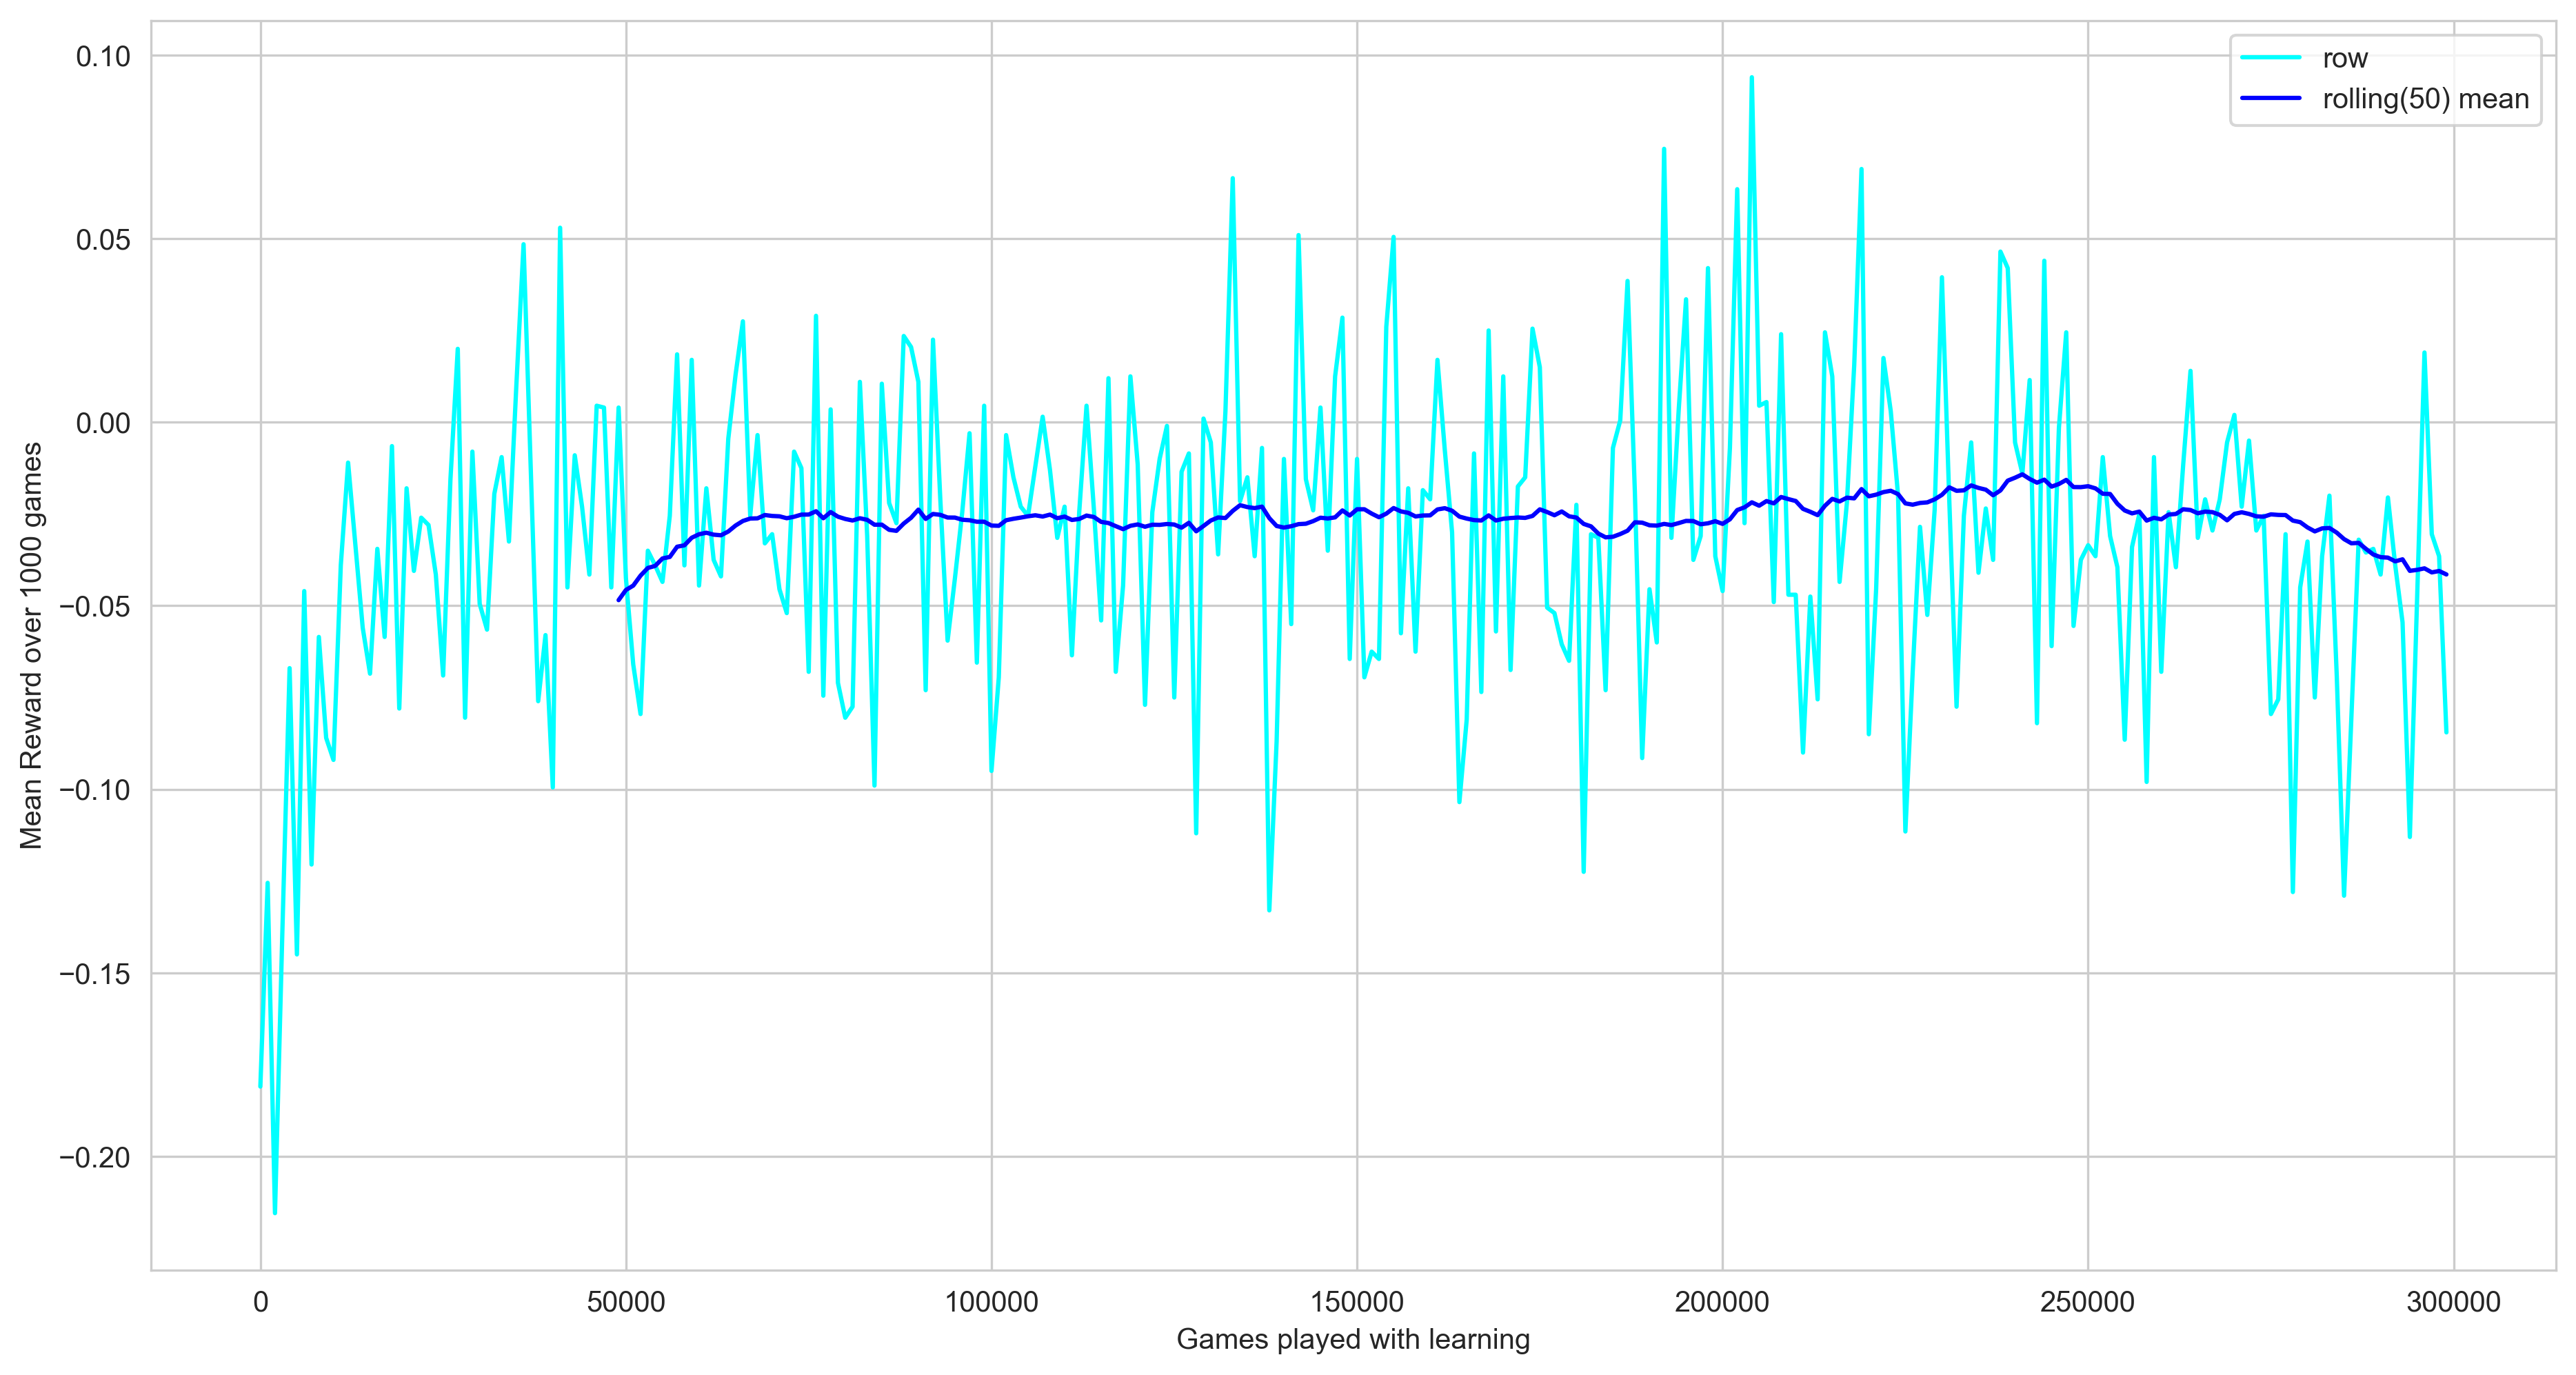

Final agent got mean reward -0.040 for 10000 games


In [66]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 300_000
gamma = 1
eps = study.best_params["eps"]
alpha = study.best_params["alpha"]

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha,
                                      n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.  
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.  

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).  
  
https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

In [67]:
from BlackJackCount import BlackjackCountEnv
# Система подсчета - "Половинки" на целых числах из статьи Википедии
env = BlackjackCountEnv(natural=True, double=True)

In [68]:
# example
print(env.reset())
print(env.step(2))

(14, 10, False, 0)
((24, 10, False, -2), -2.0, True, {})


### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [91]:
# constants
nA = 3
nS = 380 * 89

In [92]:
for _ in range(10):
    env = BlackjackDoubleEnv(natural=True, double=True)
    states = collect_states(env, NUM_GAMES=30_000)
    if len(states) == 380:
        break
len(states)

380

In [93]:
state_list = []
for state in states:
    for score in range(-44, 45):
        state_list.append((*state, score))
len(state_list) == nS

True

In [95]:
state_to_idx = {s: i for i, s in enumerate(state_list)}
idx_to_state = {i: s for i, s in enumerate(state_list)}

  0%|          | 0/100000 [00:00<?, ?it/s]

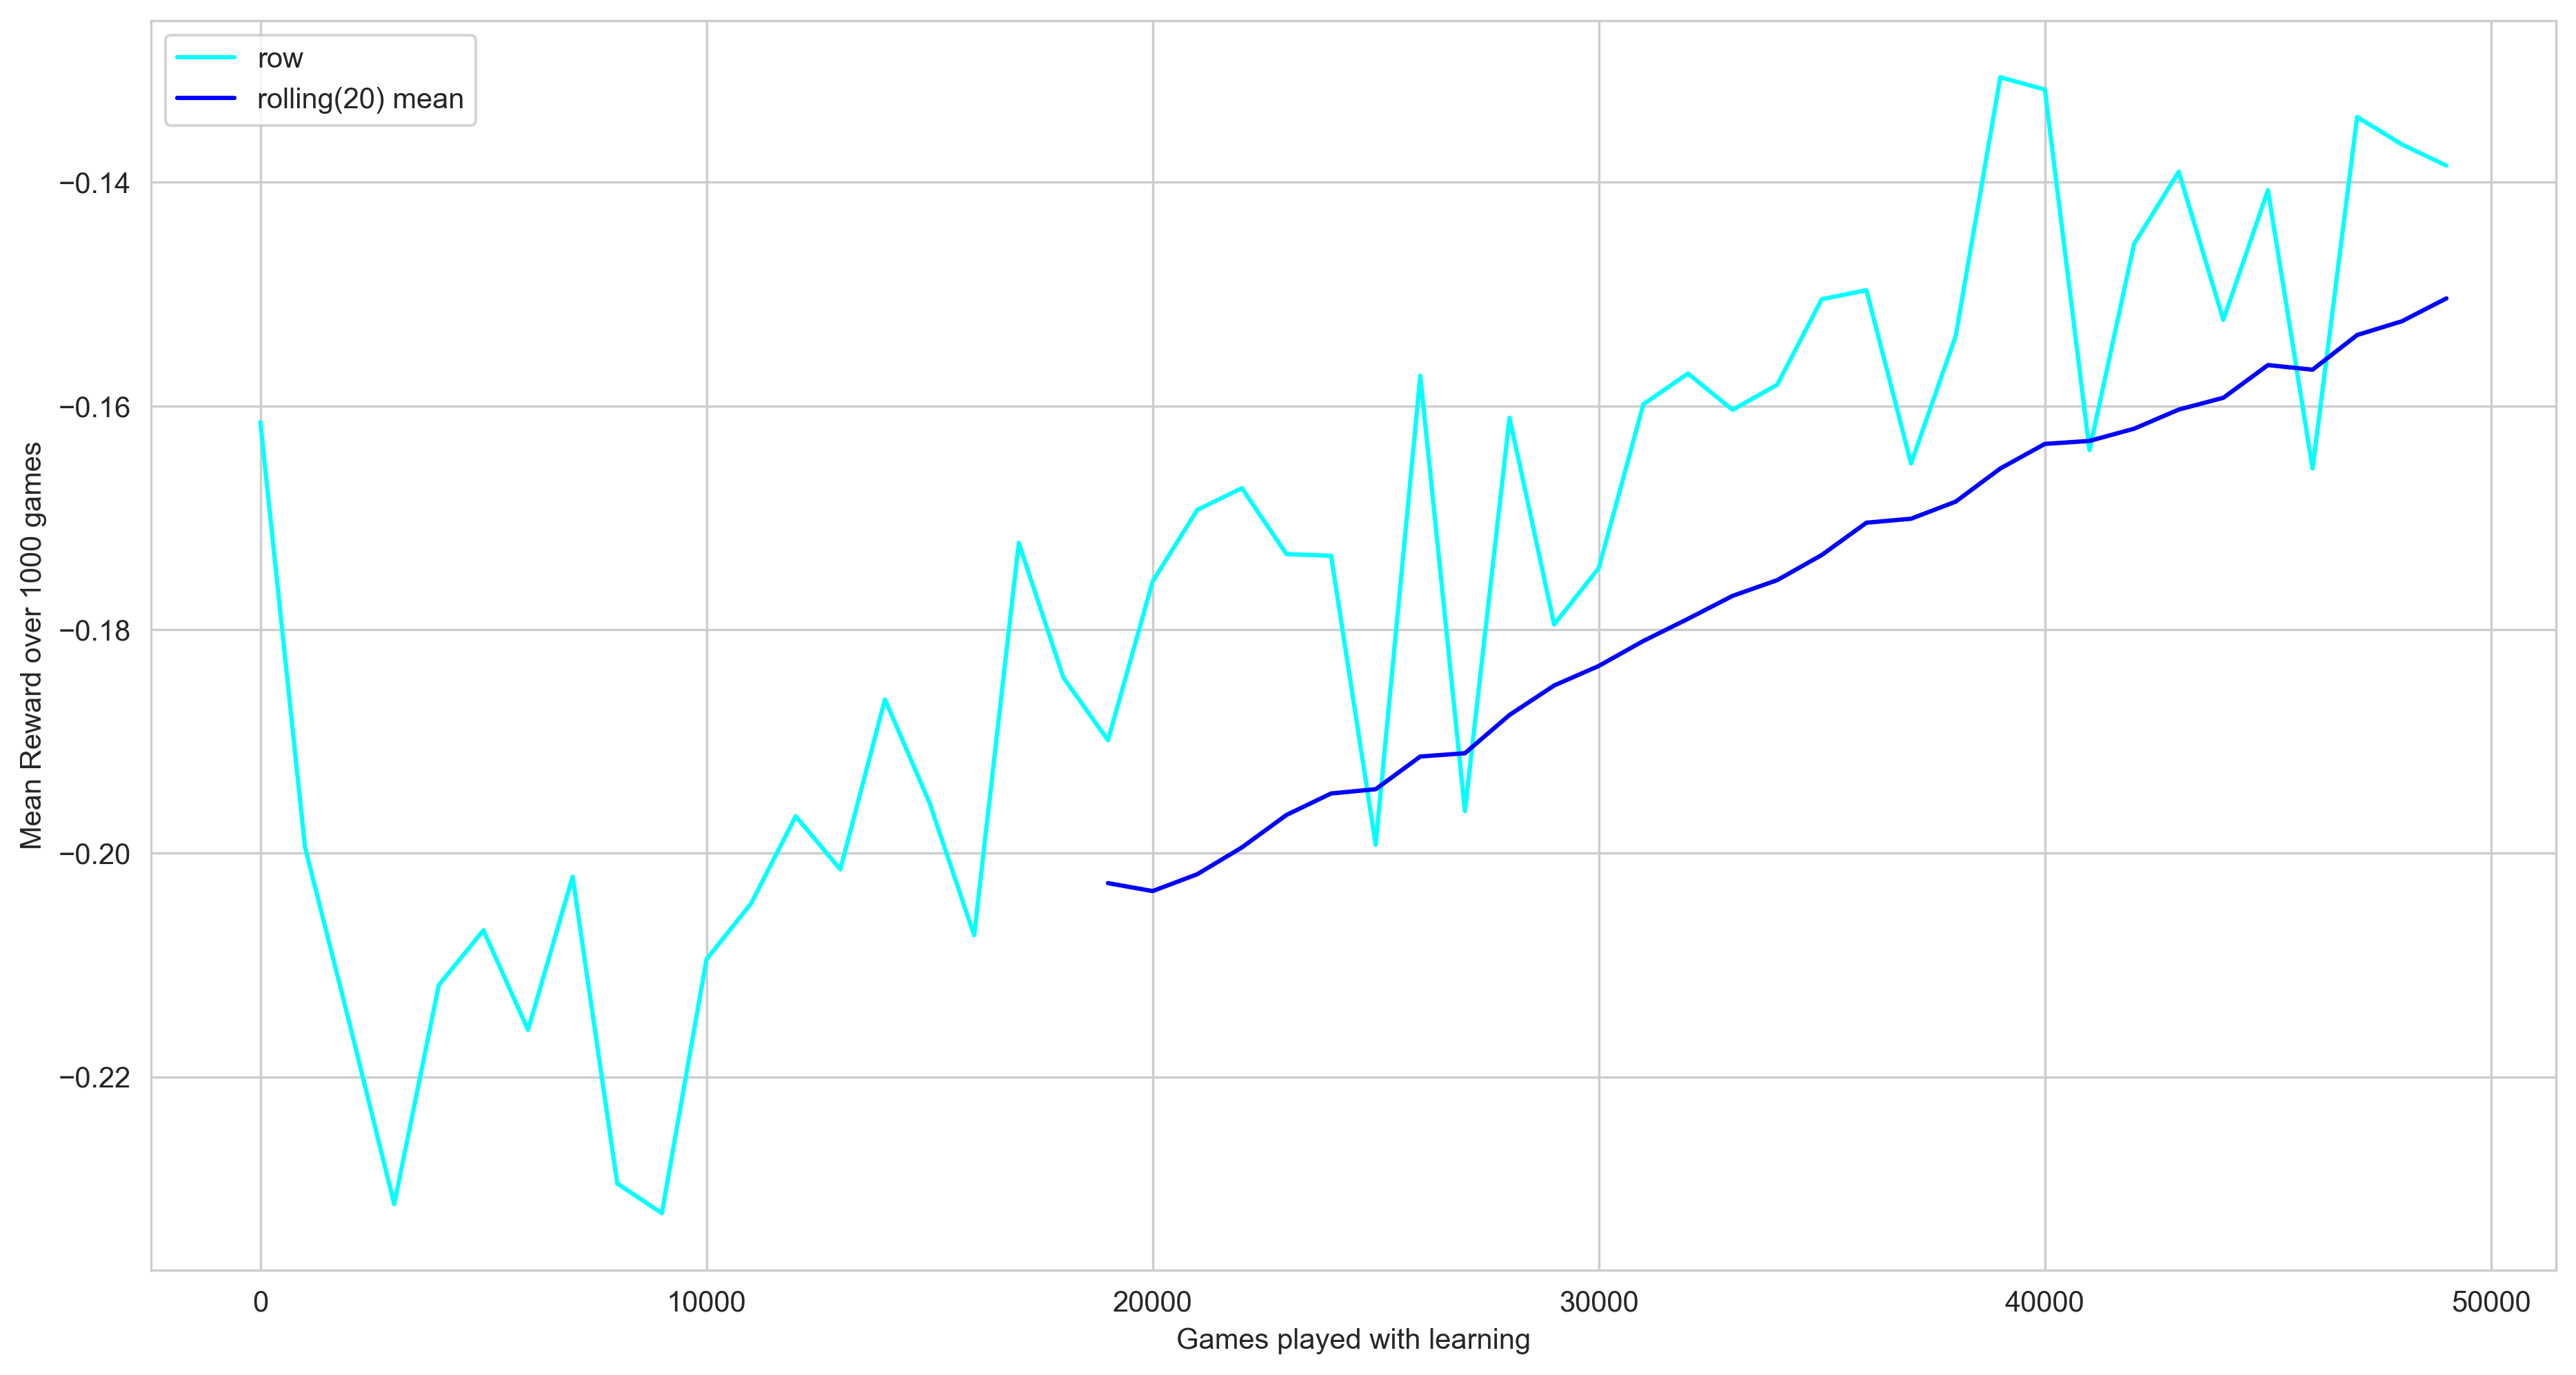

Final agent got mean reward -0.142 for 10000 games


In [99]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackCountEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
games_check = 10_000
period = 2_000
gamma = 1
eps = 0.5

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards_rolling(reward_list, period=n_check, roll=20)

res = np.mean(sample_games(agent, num_games=num_games, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [ ]:
# Видно, что обучение не достигло своей цели, но матриц много, они большие, поэтому считается уж слишком долго.

  0%|          | 0/100000 [00:00<?, ?it/s]

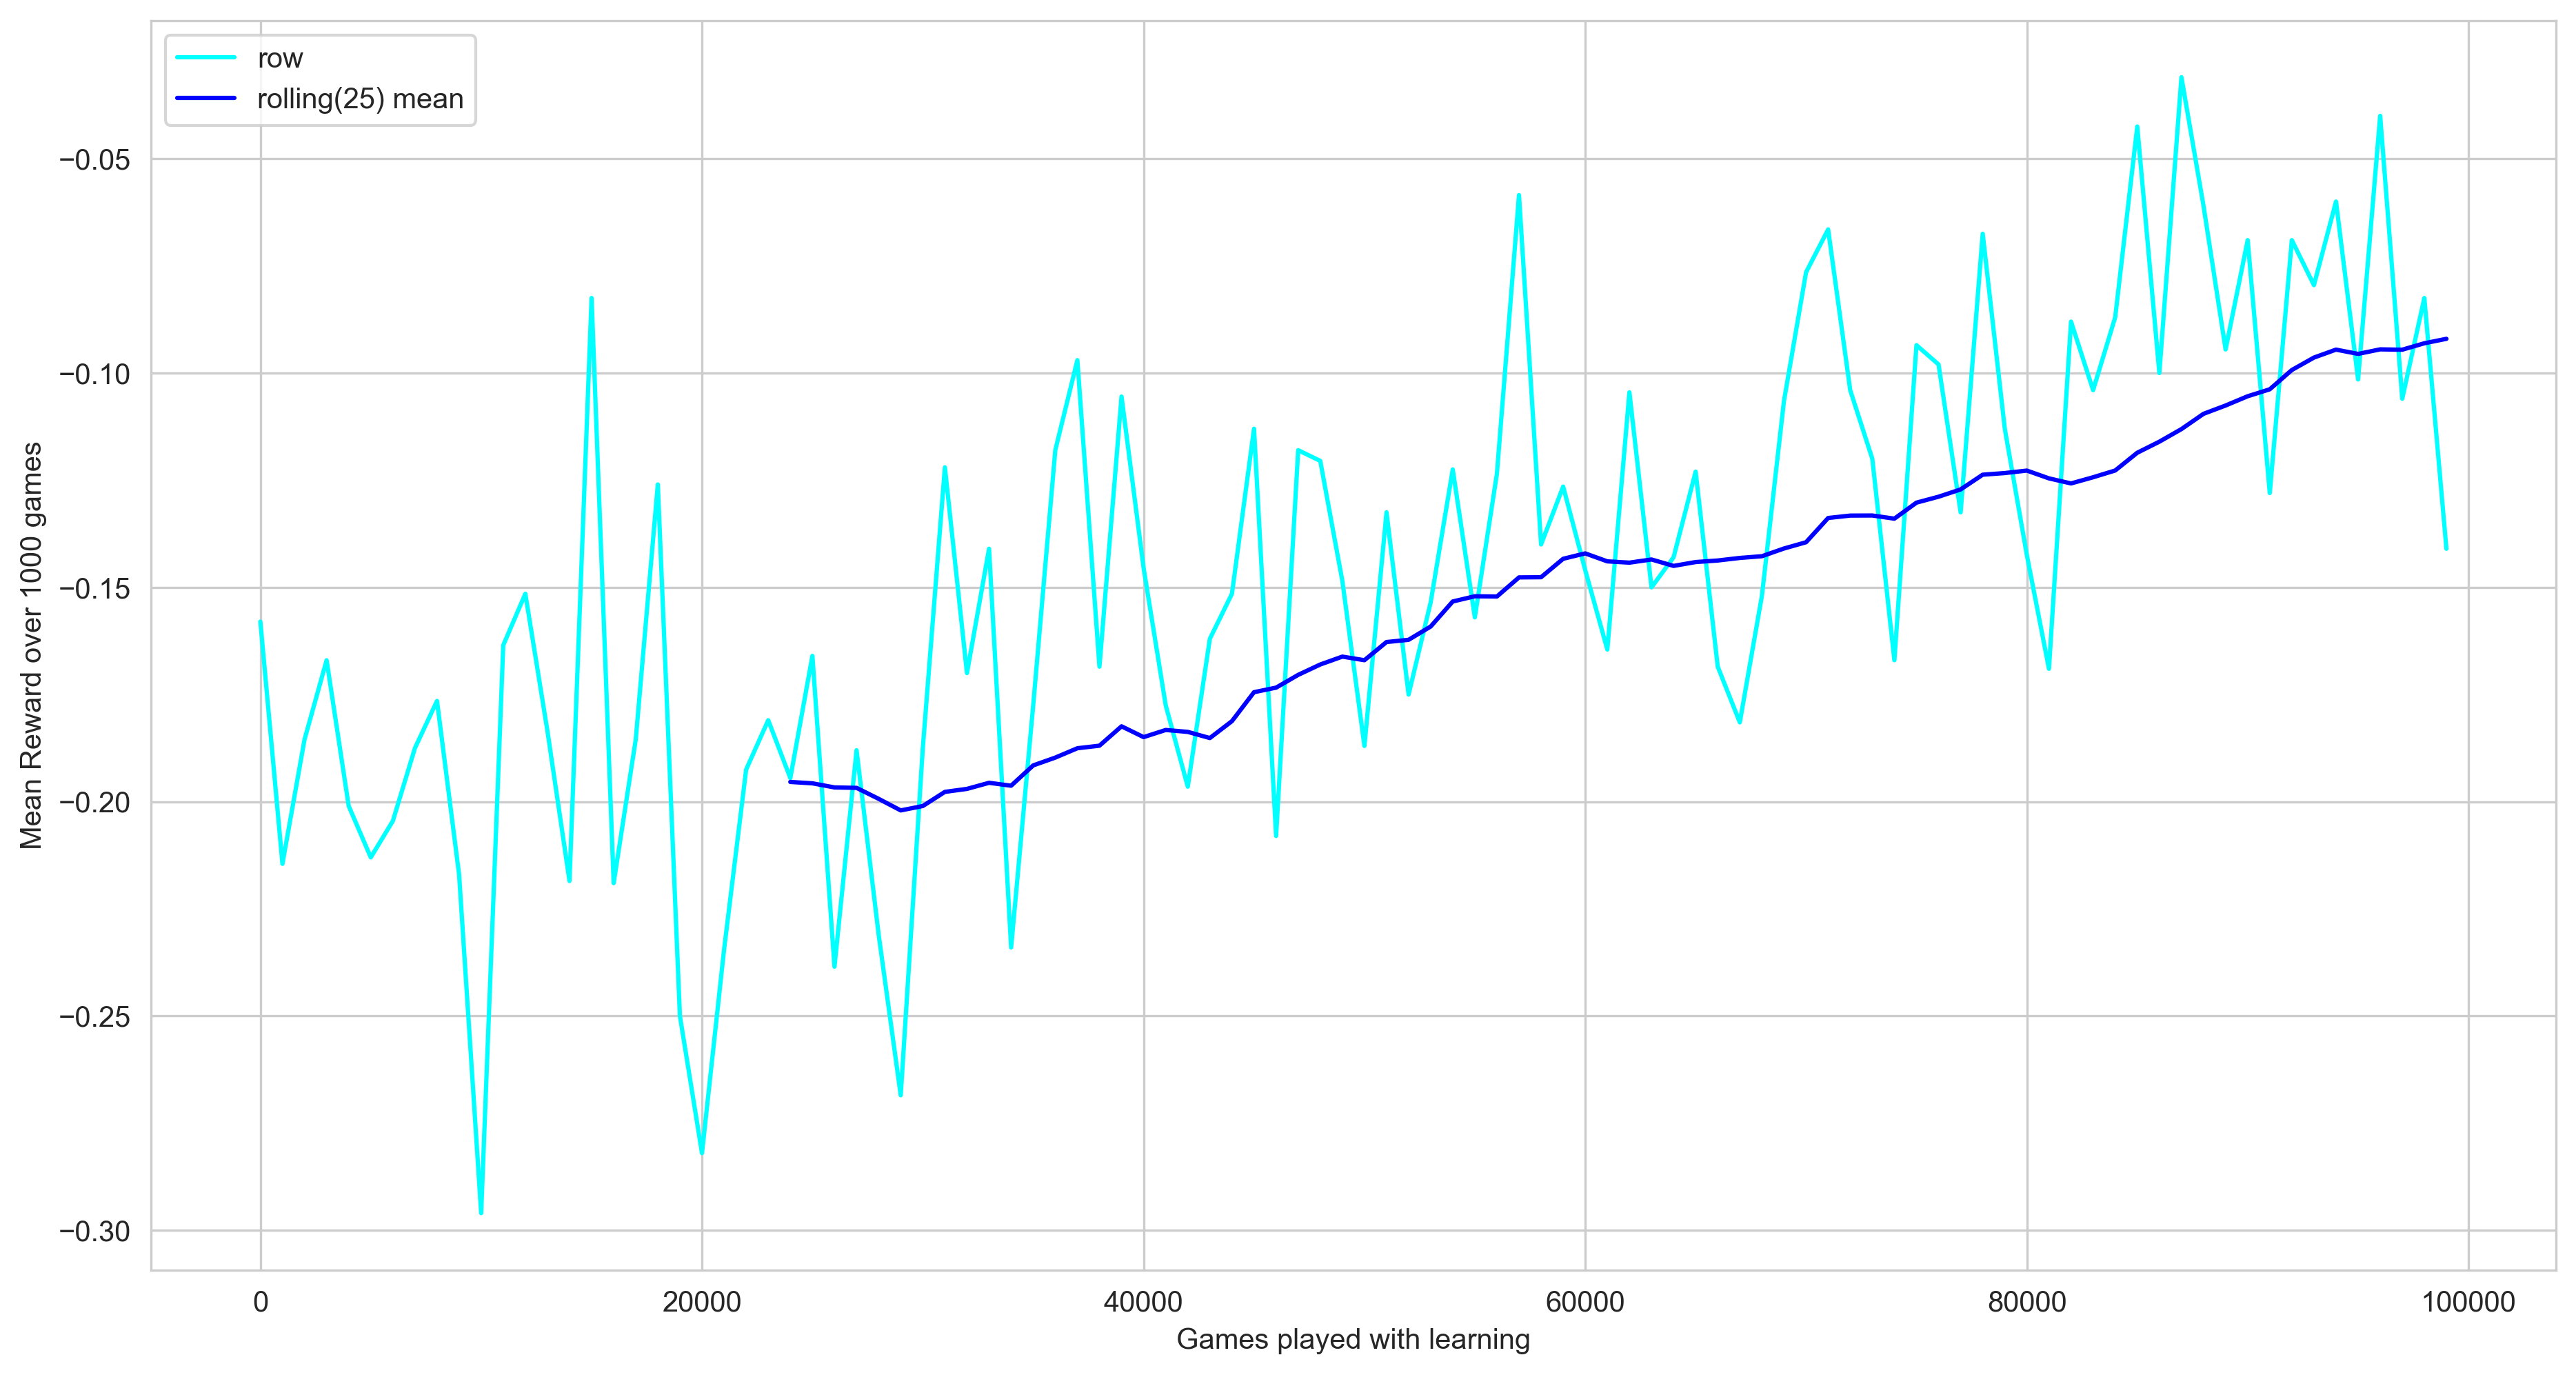

Final agent got mean reward -0.111 for 10000 games


In [100]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackCountEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
gamma = 1
eps = 0.95
alpha = 0.001

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=25)

res = np.mean(sample_games(agent, num_games=num_games_outer, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [ ]:
# Видно, что обучение не закончено, попробуем сделать болльше экспериментов. По времени получается вполне адекватно.

  0%|          | 0/2000000 [00:00<?, ?it/s]

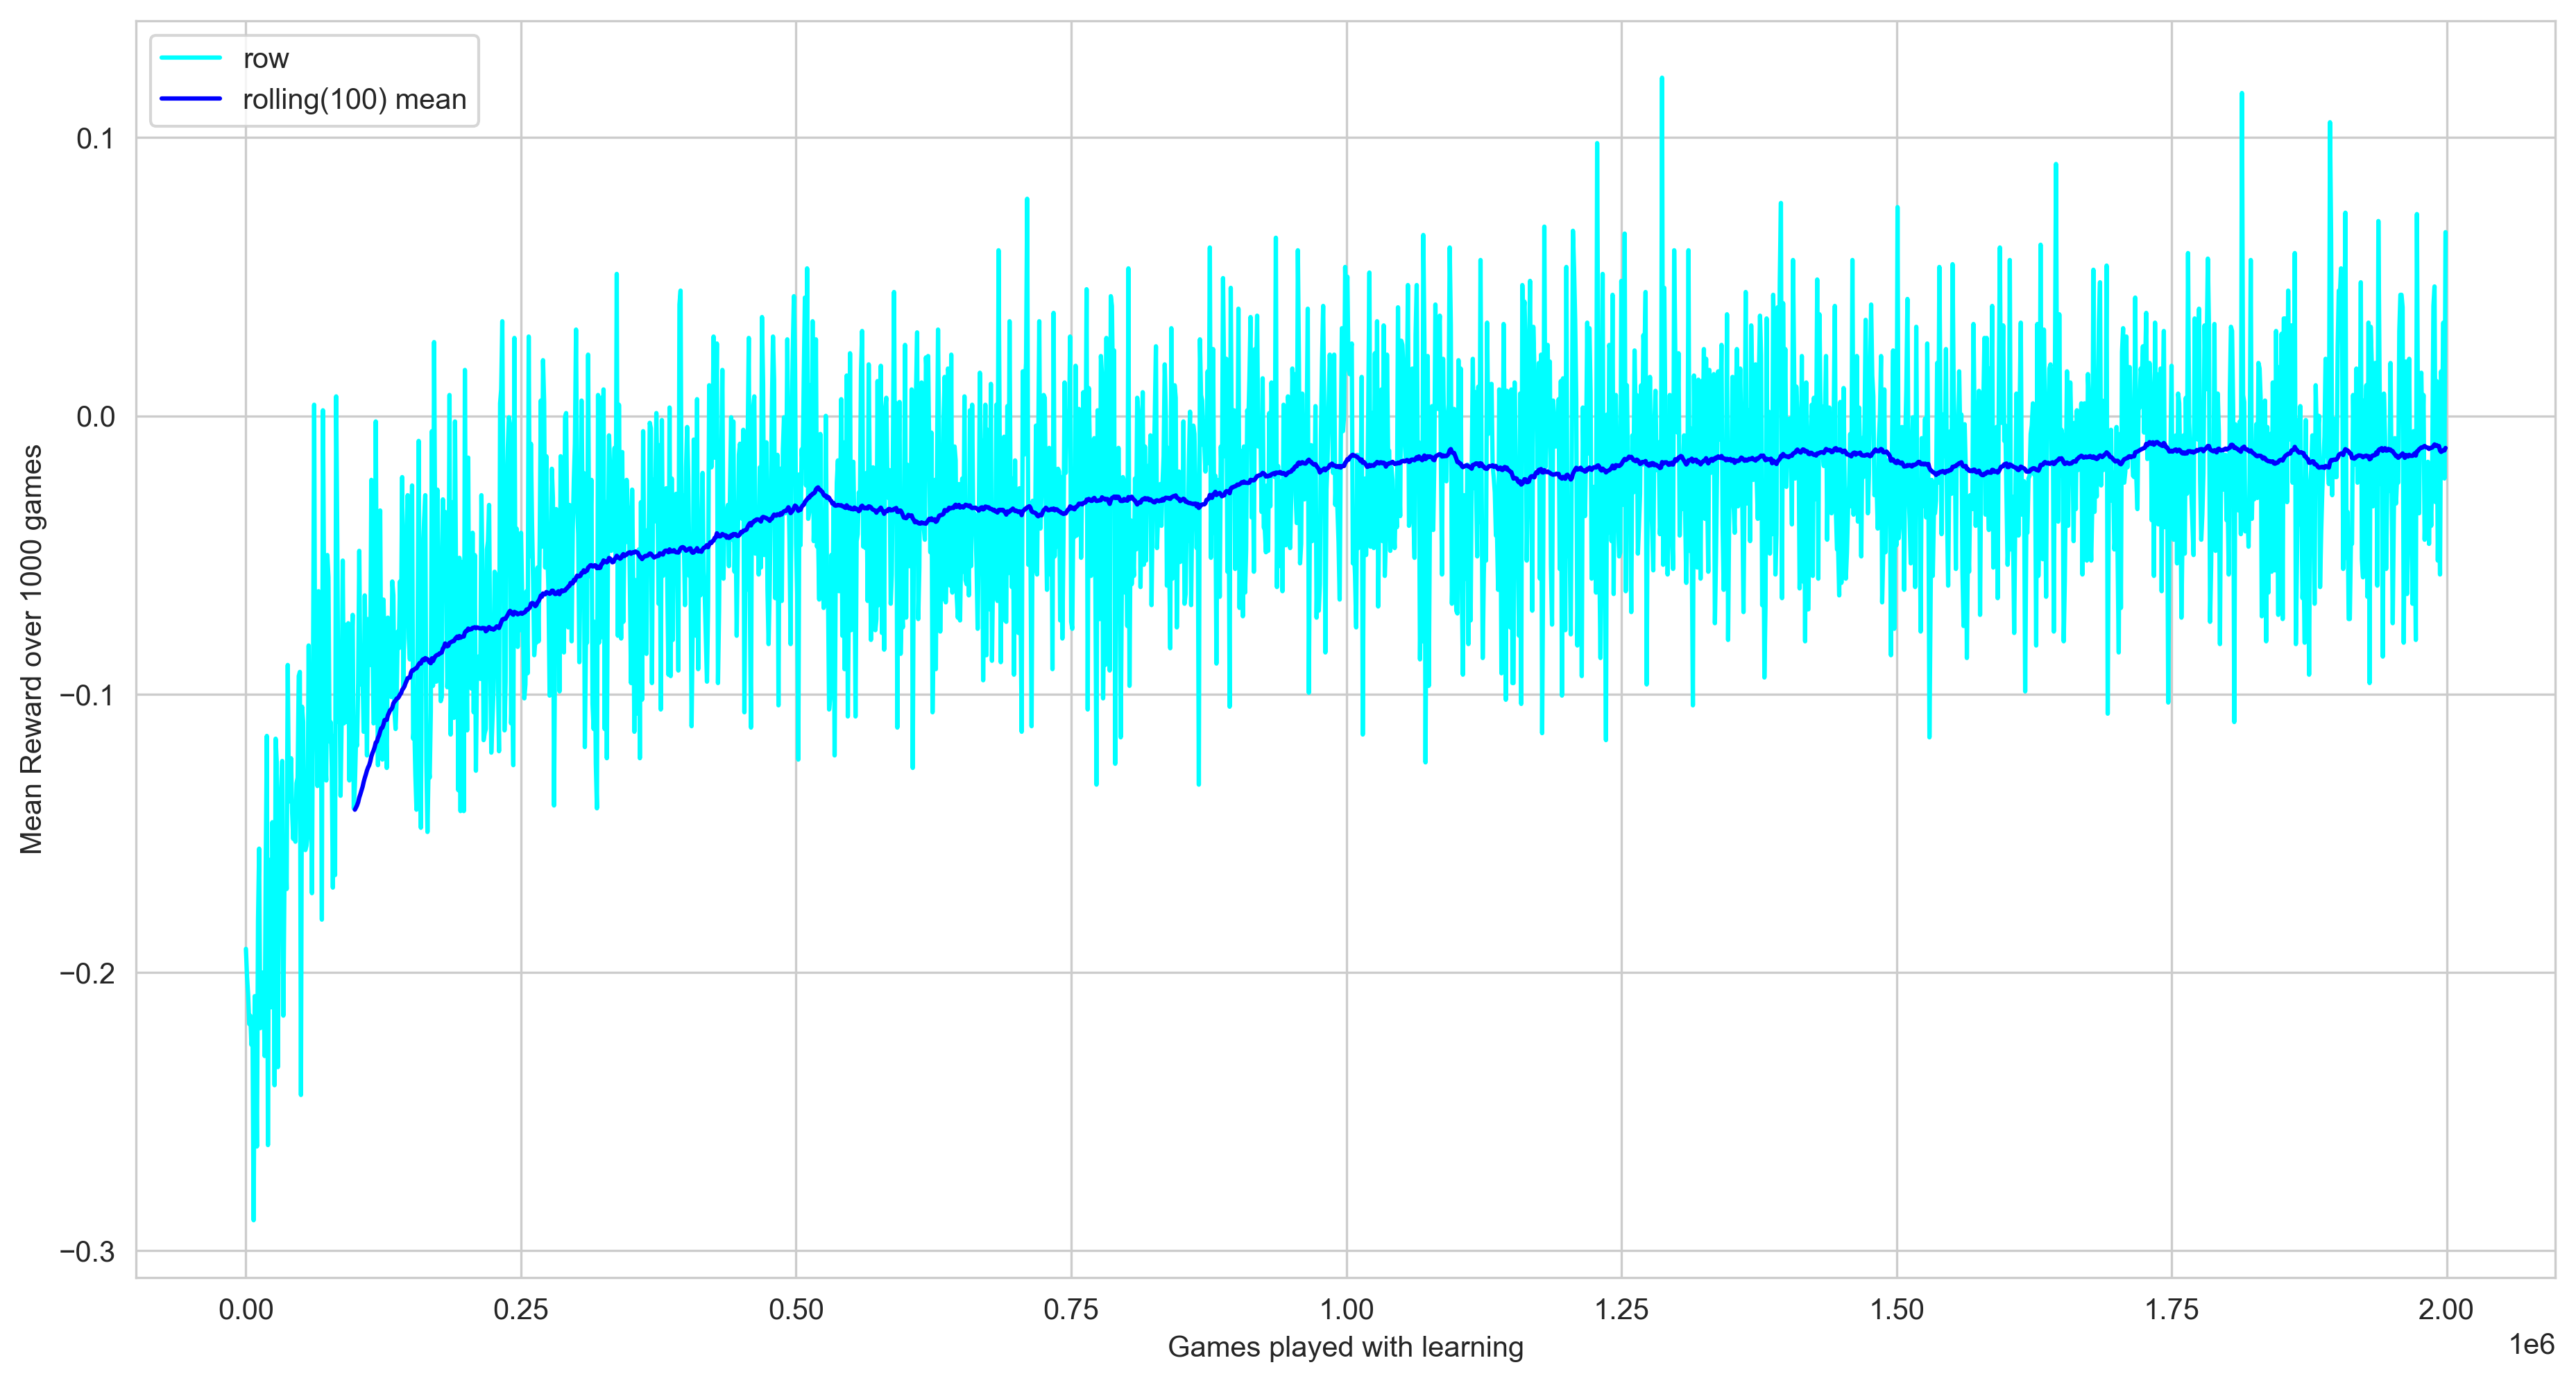

Финальная награда обученного агента равна 0.011 за 10000 игр


In [108]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackCountEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 2_000_000
gamma = 1
eps = 0.95
alpha = 0.001

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=100)

res = np.mean(sample_games(agent, num_games=num_games_outer, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()